In [2]:
#We load in the specific data needed
import polars as pl
import random
import tensorflow as tf
import numpy as np
import os
from pathlib import Path
import pandas as pd
from datetime import date
import datetime
import hvplot.polars
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import bisplrep, bisplev
from datetime import timedelta
from patsy import dmatrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.layers import BatchNormalization


# Data preperation puts

In [4]:
data = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/tech_data/data_set_train_tech_nonscaled.parquet')
data_test = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/tech_data/data_set_test_tech_nonscaled.parquet')

# firm_data = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Firm_variables/daily_firm_data_median_new.parquet')

# List of columns to drop
columns_to_drop = ['moneyness_squared_mean', 'moneyness_group', 'tau_squared_mean', 'moneyness_tau_mean', 'tau_squared_std', 'moneyness_tau_std', 'T_std', 'impl_volatility_std', 'moneyness_squared_std']

# Drop columns from datasets if they exist
data = data.drop(columns=columns_to_drop, errors='ignore')
test_data = data_test.drop(columns=columns_to_drop, errors='ignore')

# Ensure that data_val and data_test have the same column order as data_train
data_test = data_test[data.columns]

# Drop the collumn Ticker

data_c = data[data['cp_flag'] == 'C']
data_p = data[data['cp_flag'] == 'P']

data_tc = data_test[data_test['cp_flag'] == 'C']
data_tp = data_test[data_test['cp_flag'] == 'P']

In [5]:
data_put = data_p.drop(columns = ['cp_flag'])
data_put_test = data_tp.drop(columns = ['cp_flag'])

data_call = data_c.drop(columns = ['cp_flag'])
data_call_test = data_tc.drop(columns = ['cp_flag'])

In [6]:
data

date  moneyness_mean  moneyness_std  impl_volatility_mean  \
10   2019-01-02       -0.369385       0.067104              0.487425   
11   2019-01-02       -0.138625       0.075746              0.480363   
12   2019-01-02        0.131133       0.070155              0.484917   
13   2019-01-02        0.378667       0.074393              0.495387   
14   2019-01-02        0.639375       0.073574              0.485254   
...         ...             ...            ...                   ...   
5035 2020-12-31       -0.603625       0.085894              0.381434   
5036 2020-12-31       -0.385857       0.064019              0.391424   
5037 2020-12-31       -0.142900       0.091652              0.369449   
5038 2020-12-31        0.119429       0.062543              0.378481   
5039 2020-12-31        0.357222       0.080579              0.340777   

        T_mean  volume_option_mean  volume_option_std  spread_option_mean  \
10    0.015873          396.615385         884.822632            1.473846   
11    0.015873         1330.062500        2182.422583            0.860000   
12    0.015873         1891.000000        3115.252592            0.443333   
13    0.015873         1951.066667        1926.038550            0.336667   
14    0.015873         2522.500000        5223.991692            0.256875   
...        ...                 ...                ...                 ...   
5035  0.007937         9759.625000        9941.619126            0.236250   
5036  0.007937         6169.000000        5507.541073            0.347143   
5037  0.007937        11490.100000       17047.601848            0.448000   
5038  0.007937        11888.571429       17047.082124            0.617143   
5039  0.007937         7641.444444       11269.282410            0.614444   

      spread_option_std  prc_option_mean  ...  cp_flag  FF_rate  gold_price  \
10             1.264282        32.380000  ...        C     2.40  449.000000   
11             0.812970        21.559375  ...        C     2.40  449.000000   
12             0.362702        16.921000  ...        C     2.40  449.000000   
13             0.263213        12.057667  ...        C     2.40  449.000000   
14             0.236410         7.835938  ...        C     2.40  449.000000   
...                 ...              ...  ...      ...      ...         ...   
5035           0.226775         5.599375  ...        P     0.09  670.825806   
5036           0.384695         8.597857  ...        P     0.09  670.825806   
5037           0.526050        13.340000  ...        P     0.09  670.825806   
5038           0.671360        20.870000  ...        P     0.09  670.825806   
5039           0.639651        28.892778  ...        P     0.09  670.825806   

      reces_indi  10Y_RIR  1Y_bond  2Y_bond  OPEN_vix  CLOSE_vix  hi-lo_vix  
10      0.130000     2.66   2.5342   2.5442     31.72      28.57       3.17  
11      0.130000     2.66   2.5342   2.5442     31.72      28.57       3.17  
12      0.130000     2.66   2.5342   2.5442     31.72      28.57       3.17  
13      0.130000     2.66   2.5342   2.5442     31.72      28.57       3.17  
14      0.130000     2.66   2.5342   2.5442     31.72      28.57       3.17  
...          ...      ...      ...      ...       ...        ...        ...  
5035    3.042903     0.93   0.1105   0.1443     21.50      21.31       1.26  
5036    3.042903     0.93   0.1105   0.1443     21.50      21.31       1.26  
5037    3.042903     0.93   0.1105   0.1443     21.50      21.31       1.26  
5038    3.042903     0.93   0.1105   0.1443     21.50      21.31       1.26  
5039    3.042903     0.93   0.1105   0.1443     21.50      21.31       1.26  

[10060 rows x 51 columns]

# Feature permutation

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

def feature_permutation_importance(train_data, n_estimators=100, random_state=42, verbose=True):
    """
    Perform permutation importance on the training data to identify the top features.
    
    Parameters:
    - train_data (pd.DataFrame): The training dataset.
    - n_estimators (int): Number of estimators (trees) for the RandomForestRegressor.
    - random_state (int): Seed for reproducibility.
    - verbose (bool): If True, prints progress information.
    
    Returns:
    - feature_importances (pd.DataFrame): A dataframe containing feature names and their importance.
    """
    # Prepare the train data
    X_train = train_data.drop(columns=['impl_volatility', 'date', 'cp_flag'])  # Drop unwanted columns
    y_train = train_data['impl_volatility']  # Target variable (implied volatility)

    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Train a RandomForestRegressor model
    lstm_model = LSTM(n_estimators=n_estimators, random_state=random_state)
    
    if verbose:
        print(f"Training RandomForest model with {n_estimators} trees...")

    rf_model.fit(X_train_scaled, y_train)

    if verbose:
        print("Performing permutation importance...")

    # Perform permutation importance on the training data
    perm_importance = permutation_importance(rf_model, X_train_scaled, y_train, n_repeats=5, random_state=random_state, scoring='r2')

    # Create a DataFrame for feature importances
    feature_importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': perm_importance.importances_mean,
        'Importance_std': perm_importance.importances_std
    })

    # Sort by importance
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    return feature_importances


def plot_elbow_curve(feature_importances):
    """
    Plot an elbow curve to determine how many features to select based on permutation importance.
    
    Parameters:
    - feature_importances (pd.DataFrame): A dataframe containing feature names and their importance.
    """
    # Cumulative importance to capture the "elbow"
    cumulative_importance = np.cumsum(feature_importances['Importance'])

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, marker='o', linestyle='--')
    plt.title('Elbow Plot of Feature Importance')
    plt.xlabel('Number of Features')
    plt.ylabel('Cumulative Importance')
    plt.grid(True)
    plt.show()


def select_top_features(feature_importances, threshold=0.005):
    """
    Select top features based on a cumulative importance threshold.
    
    Parameters:
    - feature_importances (pd.DataFrame): A dataframe containing feature names and their importance.
    - threshold (float): Cumulative importance threshold (e.g., 0.85 for 85%).
    
    Returns:
    - selected_features (list): A list of top features to use in the model.
    """
    cumulative_importance = np.cumsum(feature_importances['Importance'])
    
    # Find how many features explain the threshold (e.g., 85%) of importance
    num_features = np.argmax(cumulative_importance >= threshold) + 1
    
    selected_features = feature_importances['Feature'].iloc[:num_features].tolist()
    print(f"\nSelected {num_features} features based on an {threshold*100}% importance threshold.")
    
    return selected_features


# Example usage for tot_data_train_c
print("Evaluating features for Call options...")
feature_importances_call = feature_permutation_importance(data_c, verbose=True)

# Display top features and their importance
print("\nFeature importances for Call options:")
print(feature_importances_call)

# Plot the elbow curve to decide on the number of features
plot_elbow_curve(feature_importances_call)

# Select top features (e.g., 85% cumulative importance)
selected_features_call = select_top_features(feature_importances_call, threshold=0.005)

print("\nSelected top features for Call options:")
print(selected_features_call)

# Example usage for tot_data_train_p
print("\nEvaluating features for Put options...")
feature_importances_put = feature_permutation_importance(data_p, verbose=True)

# Display top features and their importance
print("\nFeature importances for Put options:")
print(feature_importances_put)

# Plot the elbow curve to decide on the number of features
plot_elbow_curve(feature_importances_put)

# Select top features (e.g., 85% cumulative importance)
selected_features_put = select_top_features(feature_importances_put, threshold=0.005)

print("\nSelected top features for Put options:")
print(selected_features_put)


In [9]:
# # Get the top 9 most important features
# top_6_features_p = feature_importances_put['Feature'].head(5).tolist()

# # Print the result
# print("top_features_p =", top_6_features_p)

In [10]:
# top_10_features_c = feature_importances_call['Feature'].head(9).tolist()
# # 7
# # Print the result
# print("top_features_c =", top_10_features_c)



In [9]:
top_6_features_p=  ['prev_day_iv', 'prev2_day_iv','count_rows','ASKHI', 'spread_option_std', '1Y_bond','hi-lo_stock','LOW_vix','prev2_day_iv_std', 'T','spread_vix']
top_6_features_c=  ['prev_day_iv', 'prev2_day_iv','count_rows','ASKHI', 'spread_option_std', '1Y_bond','hi-lo_stock','LOW_vix','prev2_day_iv_std', 'T','spread_vix', 'ASK_std','moneyness','HIGH_vix']



# top_6_features_c= ['prev_day_iv', 'ASK_std','spread_vix','count_rows', 'moneyness', 'prev2_day_iv','HIGH_vix','CLOSE_vix','ASK', 'ASKHI_std','spread_vix','PRC_std','prev2_day_iv_std', 'T', 'reces_indi','1Y_bond','10Y_RIR','PRC_actual','gold_price','PRC', 'prev_day_iv_std','cumulative_return','RETX','5_day_rolling_return_stock_std','FF_rate','RET_std','volume_option' ]

In [10]:
data_c = data_c[['date', 'cp_flag', 'impl_volatility'] + top_6_features_c]
data_c_t = data_c_t[['date', 'cp_flag', 'impl_volatility'] + top_6_features_c]
data_p = data_p[['date', 'cp_flag', 'impl_volatility'] + top_6_features_p]
data_p_t = data_p_t[['date', 'cp_flag', 'impl_volatility'] + top_6_features_p]

In [14]:
data_c

date cp_flag  impl_volatility  prev_day_iv  prev2_day_iv  \
0   2019-01-02       C         0.513542     0.433020      0.000000   
1   2019-01-03       C         0.699769     0.489697      0.406842   
2   2019-01-04       C         0.423223     0.701786      0.495957   
3   2019-01-07       C         0.495448     0.424472      0.678713   
4   2019-01-08       C         0.454662     0.488975      0.428269   
..         ...     ...              ...          ...           ...   
498 2020-12-24       C         0.269321     0.306415      0.314643   
499 2020-12-28       C         0.343614     0.261537      0.296252   
500 2020-12-29       C         0.326829     0.362128      0.276957   
501 2020-12-30       C         0.370049     0.331178      0.368725   
502 2020-12-31       C         0.378872     0.377285      0.337898   

     count_rows        ASKHI  spread_option_std  1Y_bond  hi-lo_stock  \
0           152   839.653405           1.257711   2.5342    36.124852   
1           151   848.713449           0.101064   2.5342    19.922588   
2           211   823.998147           0.705308   2.4762    48.189641   
3           209   896.059759           0.768751   2.5189    25.070308   
4           171   945.121281           0.465632   2.5534    44.620136   
..          ...          ...                ...      ...          ...   
498          99  1509.180946           0.165728   0.1098    24.557898   
499         115  1626.175771           0.578592   0.1085    16.635011   
500          99  1512.175559           0.254945   0.1146    19.181114   
501          83  1444.677232           0.149268   0.1171    53.881121   
502         155  1432.727607           0.342311   0.1105    29.687439   

     LOW_vix  prev2_day_iv_std         T  spread_vix      ASK_std  moneyness  \
0      28.57          0.000000  0.011905        3.17   646.225993   0.784507   
1      22.82          0.126683  0.007937        8.64   666.298377   0.748000   
2      24.47          0.150213  0.023810        4.48   683.856522   0.743829   
3      20.84          0.166983  0.019841        3.54   664.943404   0.682957   
4      21.11          0.121479  0.015873        2.31   695.978626   0.719895   
..       ...               ...       ...         ...          ...        ...   
498    17.63          0.085884  0.019841        2.28  1390.863918   0.659434   
499    16.85          0.068955  0.015873        2.33  1418.551032   0.627722   
500    17.16          0.078518  0.011905        3.26  1366.380313   0.709929   
501    19.76          0.101756  0.007937        2.92  1374.849050   0.713554   
502    20.56          0.081475  0.023810        1.26  1366.476520   0.631000   

     HIGH_vix  
0       31.74  
1       31.46  
2       28.95  
3       24.38  
4       23.42  
..        ...  
498     19.91  
499     19.18  
500     20.42  
501     22.68  
502     21.82  

[503 rows x 17 columns]

In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

def standardize_train_test(train_data, test_data):
    """
    Standardizes the train and test datasets using the same scaler, ensuring that the transformation 
    on the test set is consistent with the train set.
    
    Parameters:
    train_data (pd.DataFrame): The training DataFrame to be standardized.
    test_data (pd.DataFrame): The test DataFrame to be standardized using the same scaler.

    Returns:
    pd.DataFrame, pd.DataFrame: The standardized train and test DataFrames.
    """
    # Step 1: Identify the columns to standardize (all except 'date', 'cp_flag', and 'impl_volatility')
    columns_to_exclude = ['date', 'cp_flag', 'impl_volatility']
    columns_to_standardize = [col for col in train_data.columns if col not in columns_to_exclude]
    
    # Step 2: Initialize the StandardScaler
    scaler = StandardScaler()
    
    # Step 3: Fit the scaler on the training data and transform the training set
    train_data[columns_to_standardize] = scaler.fit_transform(train_data[columns_to_standardize])
    
    # Step 4: Use the same scaler to transform the test set
    test_data[columns_to_standardize] = scaler.transform(test_data[columns_to_standardize])
    
    # Return the standardized train and test DataFrames
    return train_data, test_data

# Example usage:
# Assuming `data_c` is the training DataFrame and `data_c_t` is the test DataFrame
standardized_train_data_c, standardized_test_data_c_t = standardize_train_test(data_c, data_c_t)

standardized_train_data_p, standardized_test_data_p_t = standardize_train_test(data_p, data_p_t)

# Preview the standardized DataFrames
standardized_train_data_c.head()
standardized_test_data_c_t.head()


date cp_flag  impl_volatility  prev_day_iv  prev2_day_iv  count_rows  \
0 2021-01-04       C         0.468633    -0.538509     -0.500352    0.537126   
1 2021-01-05       C         0.398098    -0.152020     -0.621851    0.128414   
2 2021-01-06       C         0.521353    -0.363055     -0.089947    0.018376   
3 2021-01-07       C         0.523343     0.304776     -0.295624   -0.170260   
4 2021-01-08       C         0.415823     0.047565      0.174038    0.175573   

      ASKHI  spread_option_std   1Y_bond  hi-lo_stock   LOW_vix  \
0  1.010517          -0.585627 -1.218608    -0.039736  0.018081   
1  1.487345          -0.159118 -1.223310    -0.318169  0.191471   
2  1.236588          -0.624615 -1.219356     1.331662  0.285457   
3  0.456755          -0.267333 -1.203327    -0.217148 -0.105074   
4  1.730386          -0.409695 -1.200869     0.325263 -0.164221   

   prev2_day_iv_std         T  spread_vix   ASK_std  moneyness  HIGH_vix  
0         -0.763547  0.755059   -0.408029  1.857165  -1.371536 -0.102788  
1         -0.681343 -0.003791    0.985455  2.015703  -0.718655  0.430239  
2         -0.730367 -0.762641    0.100286  1.783830  -0.701592  0.249637  
3         -1.069032 -1.521491    0.845230  1.508404  -0.071052  0.160590  
4         -0.499419  1.513909    0.356634  1.775152  -0.117854 -0.025029

In [12]:
combined_x_c = standardized_train_data_c.drop(columns=['impl_volatility', 'date', 'cp_flag'])
combined_y_c = standardized_train_data_c['impl_volatility']

test_x_c = standardized_test_data_c_t.drop(columns=['impl_volatility', 'date', 'cp_flag'])
test_y_c = standardized_test_data_c_t['impl_volatility']

combined_x_p = standardized_train_data_p.drop(columns=['impl_volatility', 'date', 'cp_flag'])
combined_y_p = standardized_train_data_p['impl_volatility']

test_x_p = standardized_test_data_p_t.drop(columns=['impl_volatility', 'date', 'cp_flag'])
test_y_p = standardized_test_data_p_t['impl_volatility']

In [520]:
combined_x_c

prev_day_iv  prev2_day_iv  count_rows     ASKHI  spread_option_std  \
0      -0.230115     -2.204624    0.128414 -1.221216           1.473547   
1       0.027649     -0.326934    0.112694 -1.189493          -0.720504   
2       0.992224      0.084355    1.055876 -1.276032           0.425691   
3      -0.268988      0.927824    1.024437 -1.023714           0.546036   
4       0.024366     -0.228043    0.427088 -0.851929          -0.028953   
..           ...           ...         ...       ...                ...   
498    -0.805906     -0.752461   -0.704730  1.123079          -0.597842   
499    -1.010010     -0.837341   -0.453215  1.532726           0.185321   
500    -0.552525     -0.926389   -0.704730  1.133564          -0.428605   
501    -0.693285     -0.502858   -0.956245  0.897224          -0.629065   
502    -0.483592     -0.645131    0.175573  0.855384          -0.262881   

      1Y_bond  hi-lo_stock   LOW_vix  prev2_day_iv_std         T  spread_vix  \
0    1.374750     0.210908  0.666266         -1.630380 -0.762641   -0.134153   
1    1.374750    -0.513379  0.200383         -0.593209 -1.521491    1.064331   
2    1.312769     0.750237  0.334071         -0.400565  1.513909    0.152870   
3    1.358400    -0.283261  0.039957         -0.263266  0.755059   -0.053085   
4    1.395268     0.590670  0.061834         -0.635816 -0.003791   -0.322580   
..        ...          ...       ...               ...       ...         ...   
498 -1.216044    -0.306167 -0.220127         -0.927237  0.755059   -0.329153   
499 -1.217433    -0.660342 -0.283325         -1.065831 -0.003791   -0.318198   
500 -1.210914    -0.546525 -0.258207         -0.987539 -0.762641   -0.114434   
501 -1.208243     1.004662 -0.047547         -0.797284 -1.521491   -0.188928   
502 -1.215296    -0.076863  0.017271         -0.963329  1.513909   -0.552636   

      ASK_std  moneyness  HIGH_vix  CLOSE_vix       ASK  
0   -1.187662   0.893175  0.477271   0.478423 -1.261752  
1   -1.103395   0.396201  0.459712   0.072850 -1.199076  
2   -1.029684   0.339425  0.302312   0.338765 -1.280915  
3   -1.109084  -0.489248  0.015732  -0.066103 -1.076045  
4   -0.978794   0.013596 -0.044469  -0.022372 -0.854628  
..        ...        ...       ...        ...       ...  
498  1.938416  -0.809468 -0.264577  -0.182485  1.170111  
499  2.054649  -1.241180 -0.310355  -0.329197  1.571667  
500  1.835631  -0.122066 -0.232596  -0.122531  1.162598  
501  1.871183  -0.072719 -0.090873  -0.022372  0.928838  
502  1.836035  -1.196552 -0.144803  -0.033657  0.883837  

[503 rows x 16 columns]

In [17]:
import numpy as np
from keras import regularizers
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scikeras.wrappers import KerasRegressor
from keras.optimizers import RMSprop
import tensorflow as tf
import random

# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

# Set the seed before training
set_seed(42)

# Define the model function with variable neurons, layers, and dropout rate
def create_model(input_dim, neurons=32, layers=1, dropout_rate=0.0):
    model = Sequential()
    # Input layer using Input instead of input_dim argument
    model.add(Input(shape=(input_dim,)))  # Define the input shape explicitly

    # First hidden layer
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))  # Dropout layer after the first hidden layer

    # Additional hidden layers
    for _ in range(layers - 1):
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation='linear'))  # Output layer for regression (linear)

    # Compile the model
    model.compile(optimizer=RMSprop(learning_rate=0.0001),
                  loss='mean_squared_error',
                  metrics=['mse'])
    return model

# Wrapping the model in KerasRegressor
def create_keras_regressor(input_dim):
    return KerasRegressor(model=create_model, input_dim=input_dim, verbose=1)  # Set verbose=1 for model fit

# Define the parameter grid for trials
# param_grid = {
#     'model__neurons': [16, 32, 64],    # Number of neurons in each hidden layer
#     'model__layers': [1,2,3,4],        # Number of hidden layers
#     'model__dropout_rate': [0, 0.2, 0.5], # Dropout rate
#     'batch_size': [32],                   # Batch size for training
#     'epochs': [50],                       # Number of epochs
# }

# param_grid = {'batch_size': [32], 'epochs': [50], 'model__dropout_rate': [0.2], 'model__layers': [2], 'model__neurons': [64]} # Put
param_grid = {'batch_size': [32], 'epochs': [50], 'model__dropout_rate': [0], 'model__layers': [1], 'model__neurons': [64]} # Call

# Function to perform hyperparameter tuning, retrain the model, and test
def train_and_evaluate(combined_x, combined_y, test_x, test_y):
    # Get input dimension from the training data
    input_dim = combined_x.shape[1]
    
    # Create KerasRegressor with the correct input dimension
    model = create_keras_regressor(input_dim)

    # Initialize GridSearchCV with the model, parameter grid, and scoring
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               scoring='neg_mean_squared_error',  # Scoring based on MSE
                               verbose=3,
                               cv=3, 
                               n_jobs=-1)  # Verbose=3 for detailed progress tracking

    # Hyperparameter tuning using validation data
    print("Running hyperparameter tuning with validation data...")
    grid_search.fit(combined_x, combined_y,
                    verbose=1)

    # Get the best estimator and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print(f"Best Parameters: {best_params}")

    # In-sample evaluation on the combined training and validation set
    predictions_combined = best_model.predict(combined_x)

    r2_combined = r2_score(combined_y, predictions_combined)
    rmse_combined = np.sqrt(mean_squared_error(combined_y, predictions_combined))
    
    print(f"In-sample R²: {r2_combined:.4f}")
    print(f"In-sample RMSE: {rmse_combined:.4f}")

    # Make predictions on the test set
    predictions_test = best_model.predict(test_x)

    # Out-of-sample evaluation on the test set
    r2_test = r2_score(test_y, predictions_test)
    rmse_test = np.sqrt(mean_squared_error(test_y, predictions_test))

    print(f"Out-of-sample R²: {r2_test:.4f}")
    print(f"Out-of-sample RMSE: {rmse_test:.4f}")

    return best_model

# Call the function for Call options data
print("\nEvaluating Call options...")
# best_model_call = train_and_evaluate(train_x_c, train_y_c, combined_x_c, combined_y_c, test_x_c, test_y_c)

# # Call the function for Put options data
# print("\nEvaluating Put options...")
# best_model_put = train_and_evaluate(combined_x_p, combined_y_p, test_x_p, test_y_p)

best_model_call = train_and_evaluate(combined_x_c, combined_y_c, test_x_c, test_y_c)



Evaluating Call options...
Running hyperparameter tuning with validation data...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Epoch 1/50
Epoch 1/50
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 0.3731 - mse: 0.3731
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 0.4090 - mse: 0.4090
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 0.5502 - mse: 0.5502
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 0.3485 - mse: 0.3485
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 0.3596 - mse: 0.3596
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 0.5260 - mse: 0.5260
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 0.2651 - mse: 0.2651
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 0.2891 - mse: 0.2891
Epoch 4/50
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 0.4334 - mse: 0.4334
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 0.2793 - mse: 0.2793
11/11 ━━━━━━━━━━━━━━━━━━━━ 

In [124]:
from sklearn.inspection import permutation_importance

import pandas as pd
results_p = permutation_importance(best_model_put, combined_x_p, combined_y_p, n_repeats=1, random_state=42) #NEW
    # Get the feature importances and feature names
importance_p = results_p.importances_mean #NEW


# Get predictions
pred_y_p = best_model_put.predict(combined_x_p)

# Calculate mean squared error
mse_score = mean_squared_error(combined_y_p, pred_y_p)

# Assuming 'importance' is a list or array of feature importances
# Create a DataFrame with feature importance scores
feature_importance_networks = pd.DataFrame({
    'feature': combined_x_p.columns,  # Assuming feature names come from 'combined_x_p'
    'importance': importance_p  # Assuming 'importance' is a list or array of the same length as the number of features
})

# Print the MSE score (separately from the feature importances)
print(f"Mean Squared Error (MSE): {mse_score}")

# Sort by 'importance' in descending order
sorted_importance_p = feature_importance_networks.sort_values(by='importance', ascending=False)

# Display sorted feature importances
(sorted_importance_p)



16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step
16/16 ━━━━━━━━━━

feature  importance
31         count_rows    0.139670
7               ASKHI    0.068118
34    prev_day_iv_std    0.067818
2         prev_day_iv    0.055837
37  spread_option_std    0.054424
..                ...         ...
29          CLOSE_vix   -0.013203
22         reces_indi   -0.018532
9           vol_stock   -0.021754
38          BIDLO_std   -0.025681
43            BID_std   -0.053937

[63 rows x 2 columns]

In [376]:
from sklearn.inspection import permutation_importance

import pandas as pd
results_c = permutation_importance(best_model_call, combined_x_c, combined_y_c, n_repeats=1, random_state=42) #NEW
    # Get the feature importances and feature names
importance_c = results_c.importances_mean #NEW


# Get predictions
pred_y_c = best_model_call.predict(combined_x_c)

# Calculate mean squared error
mse_score = mean_squared_error(combined_y_c, pred_y_c)

# Assuming 'importance' is a list or array of feature importances
# Create a DataFrame with feature importance scores
feature_importance_networks = pd.DataFrame({
    'feature': combined_x_c.columns,  # Assuming feature names come from 'combined_x_p'
    'importance': importance_c  # Assuming 'importance' is a list or array of the same length as the number of features
})

# Print the MSE score (separately from the feature importances)
print(f"Mean Squared Error (MSE): {mse_score}")

# Sort by 'importance' in descending order
sorted_importance_c = feature_importance_networks.sort_values(by='importance', ascending=False)

# Display sorted feature importances
(sorted_importance_c)



16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step
16/16 ━━━━━━━━━━━━━━━━━

feature  importance
2      prev_day_iv    0.158991
44         ASK_std    0.153867
30      spread_vix    0.147391
31      count_rows    0.141453
0        moneyness    0.112280
..             ...         ...
58    OPEN_vix_std    0.000000
59    HIGH_vix_std    0.000000
60     LOW_vix_std    0.000000
61   CLOSE_vix_std    0.000000
62  spread_vix_std    0.000000

[63 rows x 2 columns]

In [380]:
sorted_importance_p.head(20)

feature  importance
31         count_rows    0.139670
7               ASKHI    0.068118
34    prev_day_iv_std    0.067818
2         prev_day_iv    0.055837
37  spread_option_std    0.054424
24            1Y_bond    0.052548
18        hi-lo_stock    0.051092
28            LOW_vix    0.048109
27           HIGH_vix    0.042529
35   prev2_day_iv_std    0.040243
1                   T    0.035036
30         spread_vix    0.030899
13               RETX    0.030679
45           RETX_std    0.029610
40            PRC_std    0.029562
51   spread_stock_std    0.026822
26           OPEN_vix    0.026557
8                 PRC    0.024774
3        prev2_day_iv    0.023804
25            2Y_bond    0.020829

In [416]:
sorted_importance_c.head(30)

feature  importance
2                      prev_day_iv    0.158991
44                         ASK_std    0.153867
30                      spread_vix    0.147391
31                      count_rows    0.141453
0                        moneyness    0.112280
3                     prev2_day_iv    0.105518
27                        HIGH_vix    0.101608
29                       CLOSE_vix    0.097298
12                             ASK    0.091747
39                       ASKHI_std    0.087307
40                         PRC_std    0.086200
35                prev2_day_iv_std    0.084606
1                                T    0.079118
22                      reces_indi    0.077287
24                         1Y_bond    0.076581
23                         10Y_RIR    0.075770
14                      PRC_actual    0.073572
21                      gold_price    0.071206
8                              PRC    0.063952
10                             RET    0.062180
34                 prev_day_iv_std    0.060770
13                            RETX    0.060433
15               cumulative_return    0.060361
49  5_day_rolling_return_stock_std    0.058583
20                         FF_rate    0.057079
42                         RET_std    0.051826
4                    volume_option    0.051441
25                         2Y_bond    0.049685
7                            ASKHI    0.049552
9                        vol_stock    0.048151

<Figure size 2000x600 with 0 Axes>

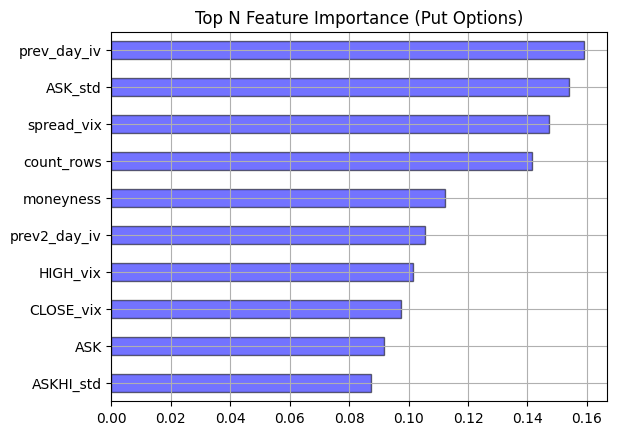

In [379]:
import matplotlib.pyplot as plt

def plot_feature_importance_barplot(sorted_importance, top_n=5):
    """
    Create a horizontal bar plot showing the top N feature importance.

    Parameters:
    sorted_importance (pd.DataFrame): Sorted feature importance DataFrame.
    top_n (int): Number of top features to plot.
    """
    # Select the top N features based on importance
    top_features = sorted_importance.head(top_n)

    # Sort the top N features by importance for plotting
    top_features = top_features.sort_values(by='importance', ascending=True)

    # Plot the top N feature importance
    plt.figure(figsize=(20, 6))
    ax = top_features.plot(kind='barh', x='feature', y='importance', color='blue', alpha=0.55, edgecolor='black', linewidth=1)
    
    # Remove the y-label
    ax.set_ylabel('')
    
    # Remove the legend
    ax.get_legend().remove()
    
    # Add grid and title
    plt.grid(True)
    ax.set_title('Top N Feature Importance (Put Options)')
    
    # plt.tight_layout()  # Optional: for better layout
    plt.show()

# Example usage: Plot the top 5 features from Put options data
plot_feature_importance_barplot(sorted_importance_c, top_n=10)


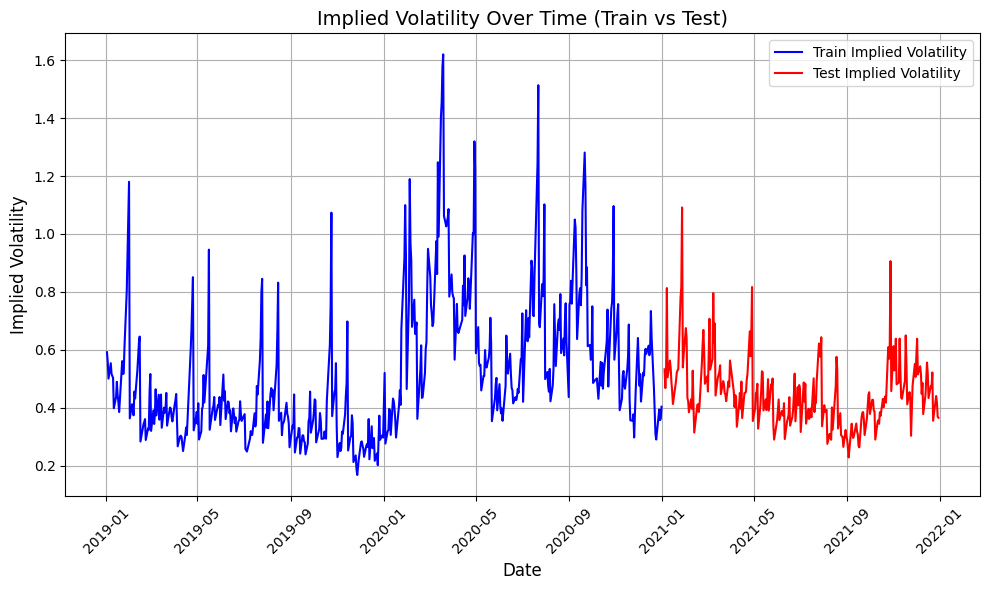

In [87]:
import matplotlib.pyplot as plt

# Assuming 'standardized_train_data_c' and 'standardized_test_data_c_t' are already pandas DataFrames
# Plotting the implied volatility for both training and testing data

plt.figure(figsize=(10, 6))

# Plot training data
plt.plot(standardized_train_data_p['date'], standardized_train_data_p['impl_volatility'], color='b', label='Train Implied Volatility')

# Plot testing data
plt.plot(standardized_test_data_p_t['date'], standardized_test_data_p_t['impl_volatility'], color='r', label='Test Implied Volatility')

# Adding title and labels
plt.title('Implied Volatility Over Time (Train vs Test)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Implied Volatility', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [13]:
import numpy as np

def create_lstm_sequences_with_target(data, target_column='impl_volatility', window_size=30):
    """
    Create LSTM sequences from the data with the specified window size, and separate the target column as y.
    
    Parameters:
    data (pd.DataFrame): The input standardized DataFrame for LSTM.
    target_column (str): The column to be used as the target (y).
    window_size (int): The number of timesteps (rows) to include in each sequence.

    Returns:
    X (np.array): 3D array shaped as (samples, window_size, features) for LSTM input.
    y (np.array): 1D array of target values corresponding to the last time step in each sequence.
    """
    # Step 1: Drop columns you don't want in the model, like 'date' and 'cp_flag'
    columns_to_exclude = ['date', 'cp_flag']
    data = data.drop(columns=columns_to_exclude)

    # Step 2: Separate the target column from the features
    target = data[target_column].values
    data = data.drop(columns=[target_column])

    # Step 3: Convert the remaining DataFrame to a NumPy array (X data)
    data_values = data.values

    # Step 4: Create sequences of the data with the specified window size
    X_sequences = []
    y_sequences = []
    
    for i in range(len(data_values) - window_size):
        X_sequences.append(data_values[i:i + window_size])  # Flatten the sequence
        y_sequences.append(target[i + window_size -1])    

    # Debugging: Print lengths of the sequences
    print(f"Length of X_sequences: {len(X_sequences)}")
    print(f"Length of y_sequences: {len(y_sequences)}")   

    # Convert the lists of sequences to NumPy arrays
    X_sequences = np.array(X_sequences)
    y_sequences = np.array(y_sequences)

    return X_sequences, y_sequences

# Example usage:
# Assuming `standardized_train_data_c` is the DataFrame you want to transform
X_train_reshaped_c, y_train_c = create_lstm_sequences_with_target(standardized_train_data_c, window_size=5)
X_test_reshaped_c, y_test_c = create_lstm_sequences_with_target(standardized_test_data_c_t, window_size=5)

X_train_reshaped_p, y_train_p = create_lstm_sequences_with_target(standardized_train_data_p, window_size=5)
X_test_reshaped_p, y_test_p = create_lstm_sequences_with_target(standardized_test_data_p_t, window_size=5)

# Check if the lengths match before proceeding with training
print(f"X_train_reshaped shape: {X_train_reshaped_p.shape}")
print(f"y_train shape: {y_train_c.shape}")

# Print the shapes of the resulting arrays and a small sample of the sequences
print(f"X_train_reshaped shape: {X_train_reshaped_c.shape}")  # (samples, timesteps, features)
print(f"y_train shape_call: {X_test_reshaped_c.shape}")  # (samples,)

# Print a sample of the sequences and the corresponding target
print("Sample X_train sequence (first sample):")
print(X_train_reshaped_c[0])

print("\nCorresponding y_train (target value for first sample):")
print(y_train_c[0])


Length of X_sequences: 498
Length of y_sequences: 498
Length of X_sequences: 245
Length of y_sequences: 245
Length of X_sequences: 498
Length of y_sequences: 498
Length of X_sequences: 245
Length of y_sequences: 245
X_train_reshaped shape: (498, 5, 11)
y_train shape: (498,)
X_train_reshaped shape: (498, 5, 14)
y_train shape_call: (245, 5, 14)
Sample X_train sequence (first sample):
[[-0.23011494 -2.2046242   0.12841397 -1.22121641  1.47354717  1.37474985
   0.21090756  0.66626567 -1.63037959 -0.76264111 -0.13415271 -1.1876616
   0.89317486  0.47727076]
 [ 0.02764932 -0.32693408  0.11269427 -1.18949342 -0.72050353  1.37474985
  -0.51337865  0.20038307 -0.59320897 -1.5214913   1.06433131 -1.10339538
   0.39620083  0.45971222]
 [ 0.99222369  0.08435491  1.05587595 -1.276032    0.42569091  1.31276915
   0.75023712  0.33407112 -0.4005648   1.51390947  0.15286997 -1.02968423
   0.33942509  0.3023125 ]
 [-0.26898833  0.92782376  1.02443656 -1.02371424  0.54603589  1.35839977
  -0.28326125  0.

In [89]:
arrayflat = y_train_p.flatten()

arrayflatpd = pd.DataFrame(arrayflat)

In [90]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error, r2_score
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from scikeras.wrappers import KerasRegressor
# from tensorflow.keras.layers import BatchNormalization

# # Function to create the LSTM model with specified hyperparameters
# def create_model(optimizer='adam', units=50, dropout_rate=0.2):
#     model = Sequential()
#     model.add(LSTM(units=units, return_sequences=True))
#     model.add(BatchNormalization())  # BatchNorm after the first LSTM layer
#     model.add(LSTM(units=units, return_sequences=False))  # Second LSTM layer
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(1))  # Output layer
#     model.compile(optimizer=optimizer, loss='mean_squared_error')
#     return model

# # Wrapping the model in KerasRegressor for use in GridSearchCV
# def create_keras_regressor(input_dim, timesteps=5):
#     # The input shape should now reflect the number of timesteps and features
#     return KerasRegressor(model=create_model, verbose=1)

# # Define the parameter grid for trials
# # param_grid = {
# #     'model__neurons': [16, 32, 64],    # Number of neurons in each hidden layer
# #     'model__layers': [1, 2, 3],        # Number of hidden layers
# #     'model__dropout_rate': [0, 0.2, 0.5], # Dropout rate
# #     'batch_size': [32],                # Batch size for training
# #     'epochs': [50],                    # Number of epochs
# # }

# param_grid = {
#     'units': [50, 100],
#     'dropout_rate': [0.2, 0.3],
#     'batch_size': [16, 32],
#     'epochs': [10, 20],
#     'optimizer': ['adam', 'rmsprop']
# }

# # Function to perform hyperparameter tuning, retrain the model, and test
# def train_and_evaluate(X_train_reshaped, y_train, X_test_reshaped, y_test, timesteps=5):
#     input_dim = X_train_reshaped.shape[2]  # Number of features

#     # Create KerasRegressor with the correct input dimension
#     model = KerasRegressor(build_fn=create_model, verbose=0, dropout_rate=0.2, units=100)

#     # Initialize GridSearchCV with the model, parameter grid, and scoring
#     grid_search = GridSearchCV(estimator=model,
#                                param_grid=param_grid,
#                                scoring='neg_mean_squared_error',  # Scoring based on MSE
#                                verbose=1,
#                                cv=5,  # Cross-validation
#                                n_jobs=-1)  # Use all available cores

#     # Perform the grid search
#     grid_search.fit(X_train_reshaped, y_train)

#     # Get the best estimator and parameters
#     best_model = grid_search.best_estimator_
#     best_params = grid_search.best_params_

#     print(f"Best Parameters: {best_params}")

#     # In-sample evaluation on the training set
#     predictions_train = best_model.predict(X_train_reshaped)
#     r2_train = r2_score(y_train, predictions_train)
#     rmse_train = np.sqrt(mean_squared_error(y_train, predictions_train))
    
#     print(f"In-sample R²: {r2_train:.4f}")
#     print(f"In-sample RMSE: {rmse_train:.4f}")

#     # Out-of-sample evaluation on the test set
#     predictions_test = best_model.predict(X_test_reshaped)
#     r2_test = r2_score(y_test, predictions_test)
#     rmse_test = np.sqrt(mean_squared_error(y_test, predictions_test))

#     print(f"Out-of-sample R²: {r2_test:.4f}")
#     print(f"Out-of-sample RMSE: {rmse_test:.4f}")

#     return best_model

# # Assuming you have already created `X_train_reshaped`, `y_train`, `X_test_reshaped`, and `y_test` from `create_lstm_sequences_with_target`

# # No need to reshape again, just use the variables directly:
# # X_train_reshaped and y_train are already prepared, same for X_test_reshaped and y_test

# # Now you can proceed with training the model
# # train_and_evaluate(X_train_reshaped_c, y_train_c, X_test_reshaped_c, y_test_c)

# train_and_evaluate(X_train_reshaped_p, y_train_p, X_test_reshaped_p, y_test_p)

# # If you have Put options data prepared similarly, you can call `train_and_evaluate` again for that set
# # train_and_evaluate(X_train_reshaped_put, y_train_put, X_test_reshaped_put, y_test_put)


In [91]:
# # def create_model(input_shape, neurons=64, layers=2, dropout_rate=0.2):
# #     model = Sequential()
    
# #     # Add the Input layer
# #     model.add(Input(shape=input_shape))
    
# #     # First LSTM layer
# #     model.add(LSTM(neurons, activation='softplus', return_sequences=(layers > 1)))
# #     model.add(BatchNormalization())  # Add BatchNormalization after the LSTM layer
# #     model.add(Dropout(dropout_rate))

# #     # Additional LSTM layers (if any)
# #     for _ in range(layers - 2):  # Only add intermediate LSTM layers if more than 2 layers
# #         model.add(LSTM(neurons, activation='softplus', return_sequences=True))
# #         model.add(BatchNormalization())  # Add BatchNormalization after each LSTM layer
# #         model.add(Dropout(dropout_rate))
    
# #     # Final LSTM layer (return_sequences=False)
# #     if layers > 1:
# #         model.add(LSTM(neurons, activation='softplus', return_sequences=False))
# #         model.add(BatchNormalization())  # Add BatchNormalization after the final LSTM layer
    
# #     # Output layer for regression
# #     model.add(Dense(1))

# #     # Compile the model
# #     model.compile(optimizer='adam', loss='mean_squared_error')

# #     return model

# from tensorflow.keras.layers import Input

# def create_model(input_shape, neurons=64, layers=2, dropout_rate=0.2):
#     model = Sequential()
    
#     # Add the Input layer
#     model.add(Input(shape=input_shape))
    
#     # First LSTM layer
#     model.add(LSTM(neurons, activation='softplus', return_sequences=(layers > 1)))
#     model.add(Dropout(dropout_rate))

#     # Additional LSTM layers (if any)
#     for _ in range(layers - 2):  # Only add intermediate LSTM layers if more than 2 layers
#         model.add(LSTM(neurons, activation='softplus', return_sequences=True))
#         model.add(Dropout(dropout_rate))
    
#     # Final LSTM layer (return_sequences=False)
#     if layers > 1:
#         model.add(LSTM(neurons, activation='softplus', return_sequences=False))
    
#     # Output layer for regression
#     model.add(Dense(1))

#     # Compile the model
#     model.compile(optimizer='adam', loss='mean_squared_error')

#     return model


# def create_keras_regressor(input_dim, timesteps=5):
#     # The input shape should now reflect the number of timesteps and features
#     return KerasRegressor(model=create_model, input_shape=(timesteps, input_dim), verbose=1)

# # param_grid = {
# #     'model__neurons': [16, 32, 64],    # Number of neurons in each hidden layer
# #     'model__layers': [1, 2, 3, 4],        # Number of hidden layers
# #     'model__dropout_rate': [0, 0.2, 0.5], # Dropout rate
# #     'batch_size': [32],                # Batch size for training
# #     'epochs': [50],                    # Number of epochs
# # }

# # param_grid = {'batch_size': [32], 'epochs': [50], 'model__dropout_rate': [0], 'model__layers': [2], 'model__neurons': [64]}


# param_grid = {'batch_size': [32], 'epochs': [50], 'model__dropout_rate': [0], 'model__layers': [4], 'model__neurons': [32]} #Puts

# def train_and_evaluate(X_train_reshaped, y_train, X_test_reshaped, y_test, timesteps=5):
#     input_dim = X_train_reshaped.shape[2]  # Number of features
    
#     # Create KerasRegressor with the correct input dimension
#     model = create_keras_regressor(input_dim, timesteps=timesteps)
    
#     # Initialize GridSearchCV with the model, parameter grid, and scoring
#     grid_search = GridSearchCV(estimator=model,
#                                param_grid=param_grid,
#                                scoring='neg_mean_squared_error',
#                                verbose=1,
#                                cv=5,
#                                n_jobs=-1)

#     # Perform the grid search
#     grid_search.fit(X_train_reshaped, y_train)

#     # Get the best estimator and parameters
#     best_model = grid_search.best_estimator_
#     best_params = grid_search.best_params_
    
#     print(f"Best Parameters: {best_params}")

#     # In-sample evaluation on the training set
#     predictions_train = np.squeeze(best_model.predict(X_train_reshaped))
#     print("predictions_train shape:", predictions_train.shape)
#     print("y_train shape:", y_train.shape)
    
#     # Check if shapes match
#     if predictions_train.shape != y_train.shape:
#         raise ValueError(f"Mismatch between predictions ({predictions_train.shape}) and y_train ({y_train.shape}) shape")
    
#     r2_train = r2_score(y_train, predictions_train)
#     rmse_train = np.sqrt(mean_squared_error(y_train, predictions_train))
    
#     print(f"In-sample R²: {r2_train:.4f}")
#     print(f"In-sample RMSE: {rmse_train:.4f}")

#     # Out-of-sample evaluation on the test set
#     predictions_test = np.squeeze(best_model.predict(X_test_reshaped))
#     r2_test = r2_score(y_test, predictions_test)
#     rmse_test = np.sqrt(mean_squared_error(y_test, predictions_test))

#     print(f"Out-of-sample R²: {r2_test:.4f}")
#     print(f"Out-of-sample RMSE: {rmse_test:.4f}")

#     # Plot actual vs predicted implied volatility
#     import matplotlib.pyplot as plt

#     # Filter data for the year 2021 and onwards
#     filtered_data = data[data['date'] >= '2021-01-01']

#     return best_model


# num_samples = X_train_reshaped_p.shape[0]  # 498 samples
# num_elements = X_train_reshaped_p.size      # Total number of elements, e.g., 12,450

# # Calculate the number of features per timestep
# num_timesteps = 5  # Set this value based on your understanding of the data
# num_features = num_elements // (num_samples * num_timesteps)  # Calculate the number of features per timestep

# print(f"Number of timesteps: {num_timesteps}")
# print(f"Number of features: {num_features}")

# X_train_reshaped_p = X_train_reshaped_p.reshape((num_samples, num_timesteps, num_features))
# X_test_reshaped_p = X_test_reshaped_p.reshape((X_test_reshaped_p.shape[0], num_timesteps, num_features))

# print("Reshaped X_train_reshaped_p shape:", X_train_reshaped_p.shape)
# print("Reshaped X_test_reshaped_p shape:", X_test_reshaped_p.shape)


# print("X_train_reshaped_p shape after reshape:", X_train_reshaped_p.shape)
# print("X_test_reshaped_p shape after reshape:", X_test_reshaped_p.shape)

# train_and_evaluate(X_train_reshaped_p, y_train_p, X_test_reshaped_p, y_test_p)


In [227]:
standardized_train_data_p

date cp_flag  impl_volatility  prev_day_iv  prev_day_iv  \
0   2019-01-02       P         0.591828     0.267741     0.267741   
1   2019-01-03       P         0.559444     0.323789     0.323789   
2   2019-01-04       P         0.500506     0.167837     0.167837   
3   2019-01-07       P         0.553899    -0.066139    -0.066139   
4   2019-01-08       P         0.516898     0.128343     0.128343   
..         ...     ...              ...          ...          ...   
498 2020-12-24       P         0.290516    -0.967158    -0.967158   
499 2020-12-28       P         0.394037    -1.049559    -1.049559   
500 2020-12-29       P         0.357299    -0.487410    -0.487410   
501 2020-12-30       P         0.362238    -0.706986    -0.706986   
502 2020-12-31       P         0.403666    -0.372812    -0.372812   

     prev2_day_iv  count_rows     ASKHI  spread_option_std   1Y_bond  \
0       -2.262588    0.045970 -1.256452          -0.081440  1.374750   
1        0.262222   -0.266501 -1.171131           0.402797  1.374750   
2        0.277521    0.936511 -1.406240          -0.659340  1.312769   
3        0.207987    1.155240 -1.216017          -0.639137  1.358400   
4       -0.041885    0.530299 -1.139929          -0.579198  1.395268   
..            ...         ...       ...                ...       ...   
498     -0.992162   -0.688336  1.304635          -0.504171 -1.216044   
499     -1.011999   -0.516477  1.546275          -0.743095 -1.217433   
500     -1.024716   -0.782077  1.797868          -0.699542 -1.210914   
501     -0.461716   -1.016430  1.774524          -0.029660 -1.208243   
502     -0.572507    0.561546  1.123712           0.364354 -1.215296   

     hi-lo_stock   LOW_vix  prev2_day_iv_std         T  spread_vix  
0       0.150051  0.666266         -1.684148 -0.762759   -0.134153  
1      -0.516353  0.200383         -0.852519 -1.521536    1.064331  
2       0.581203  0.334071         -0.797143  1.513572    0.152870  
3      -0.362218  0.039957         -0.854310  0.754795   -0.053085  
4       0.372549  0.061834         -0.830678 -0.003982   -0.322580  
..           ...       ...               ...       ...         ...  
498    -0.189998 -0.220127         -0.650880  0.754795   -0.329153  
499    -0.576050 -0.283325         -0.826878 -0.003982   -0.318198  
500    -0.454551 -0.258207         -0.856827 -0.762759   -0.114434  
501     1.469047 -0.047547         -0.790078 -1.521536   -0.188928  
502     0.001908  0.017271         -0.847028  1.513572   -0.552636  

[503 rows x 15 columns]

In [14]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

# Set the seed before training
set_seed(42)

from tensorflow.keras.layers import Input

def create_model(input_shape, neurons=64, layers=2, dropout_rate=0.2):
    model = Sequential()
    
    # Add the Input layer
    model.add(Input(shape=input_shape))
    
    # First LSTM layer
    model.add(LSTM(neurons, activation='softplus', return_sequences=(layers > 1)))
    model.add(Dropout(dropout_rate))

    # Additional LSTM layers (if any)
    for _ in range(layers - 2):  # Only add intermediate LSTM layers if more than 2 layers
        model.add(LSTM(neurons, activation='softplus', return_sequences=True))
        model.add(Dropout(dropout_rate))
    
    # Final LSTM layer (return_sequences=False)
    if layers > 1:
        model.add(LSTM(neurons, activation='softplus', return_sequences=False))
    
    # Output layer for regression
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model


def create_keras_regressor(input_dim, timesteps=5):
    # The input shape should now reflect the number of timesteps and features
    return KerasRegressor(model=create_model, input_shape=(timesteps, input_dim), verbose=1)

# param_grid = {
#     'model__neurons': [16, 32, 64],    # Number of neurons in each hidden layer
#     'model__layers': [1, 2, 3, 4],        # Number of hidden layers
#     'model__dropout_rate': [0, 0.2, 0.5], # Dropout rate
#     'batch_size': [32],                # Batch size for training
#     'epochs': [50],                    # Number of epochs
# }

param_grid = {'batch_size': [32], 'epochs': [50], 'model__dropout_rate': [0], 'model__layers': [1], 'model__neurons': [64]} #Calls

def train_and_evaluate(X_train_reshaped, y_train, X_test_reshaped, y_test, timesteps=5):
    input_dim = X_train_reshaped.shape[2]  # Number of features
    
    # Create KerasRegressor with the correct input dimension
    model = create_keras_regressor(input_dim, timesteps=timesteps)
    
    # Initialize GridSearchCV with the model, parameter grid, and scoring
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               scoring='neg_mean_squared_error',
                               verbose=1,
                               cv=3,
                               n_jobs=-1)

    # Perform the grid search
    grid_search.fit(X_train_reshaped, y_train)

    # Get the best estimator and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print(f"Best Parameters: {best_params}")

    # In-sample evaluation on the training set
    predictions_train = np.squeeze(best_model.predict(X_train_reshaped))
    print("predictions_train shape:", predictions_train.shape)
    print("y_train shape:", y_train.shape)
    
    # Check if shapes match
    if predictions_train.shape != y_train.shape:
        raise ValueError(f"Mismatch between predictions ({predictions_train.shape}) and y_train ({y_train.shape}) shape")
    
    r2_train = r2_score(y_train, predictions_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, predictions_train))
    
    print(f"In-sample R²: {r2_train:.4f}")
    print(f"In-sample RMSE: {rmse_train:.4f}")

    # Out-of-sample evaluation on the test set
    predictions_test = np.squeeze(best_model.predict(X_test_reshaped))
    r2_test = r2_score(y_test, predictions_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, predictions_test))

    print(f"Out-of-sample R²: {r2_test:.4f}")
    print(f"Out-of-sample RMSE: {rmse_test:.4f}")



    return best_model


# num_samples = X_train_reshaped_p.shape[0]  # 498 samples
# num_elements = X_train_reshaped_p.size      # Total number of elements, e.g., 12,450

# # Calculate the number of features per timestep
# num_timesteps = 5  # Set this value based on your understanding of the data
# num_features = num_elements // (num_samples * num_timesteps)  # Calculate the number of features per timestep

# print(f"Number of timesteps: {num_timesteps}")
# print(f"Number of features: {num_features}")

# X_train_reshaped_p = X_train_reshaped_p.reshape((num_samples, num_timesteps, num_features))
# X_test_reshaped_p = X_test_reshaped_p.reshape((X_test_reshaped_p.shape[0], num_timesteps, num_features))

# print("Reshaped X_train_reshaped_p shape:", X_train_reshaped_p.shape)
# print("Reshaped X_test_reshaped_p shape:", X_test_reshaped_p.shape)


# print("X_train_reshaped_p shape after reshape:", X_train_reshaped_p.shape)
# print("X_test_reshaped_p shape after reshape:", X_test_reshaped_p.shape)

# train_and_evaluate(X_train_reshaped_c, y_train_c, X_test_reshaped_c, y_test_c)

# Now you can proceed with training the model
best_model_p = train_and_evaluate(X_train_reshaped_p, y_train_p, X_test_reshaped_p, y_test_p)

best_model_c = train_and_evaluate(X_train_reshaped_c, y_train_c, X_test_reshaped_c, y_test_c)
# Extract and return feature importances
# feature_importances = pd.Series(lstm_model.feature_importances_, index=X_train_reshaped_p.columns)
# feature_importances

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Epoch 1/50
Epoch 1/50
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8341  
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1608  
Epoch 2/50
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4321  
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0497 
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0764 
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1110 
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0352 
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0707 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0301 
Epoch 4/50
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0350 
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0240 
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0157 
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0145 
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 

In [54]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

# Set the seed before training
set_seed(42)

# Function to calculate prediction errors
def get_prediction_errors(actual, predicted):
    """
    Compute the prediction errors between actual and predicted values.
    
    Parameters:
    actual (pd.Series or np.array): The actual values of the independent variable.
    predicted (np.array): The predicted values from the model.
    
    Returns:
    np.array: The error differences.
    """
    return actual - predicted

# Function to calculate Newey-West standard error
def newey_west_standard_error(errors, lag=1):
    """
    Computes the Newey-West standard error for the series of prediction errors.
    
    Parameters:
    - errors: Array-like of prediction errors
    - lag: Maximum lag to use for the Newey-West estimator (default is 1)
    
    Returns:
    - Newey-West standard error of the prediction errors
    """
    X = np.ones(len(errors))  # Constant term
    ols_model = sm.OLS(errors, X).fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    nw_std_error = ols_model.bse[0]
    return nw_std_error

# Update the train_and_evaluate function to save errors for DM test
def train_and_evaluate_with_errors(X_train_reshaped, y_train, X_test_reshaped, y_test, timesteps=5, data_type=''):
    input_dim = X_train_reshaped.shape[2]  # Number of features
    
    # Create KerasRegressor with the correct input dimension
    model = create_keras_regressor(input_dim, timesteps=timesteps)
    
    # Initialize GridSearchCV with the model, parameter grid, and scoring
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               scoring='neg_mean_squared_error',
                               verbose=1,
                               cv=3,
                               n_jobs=-1)

    # Perform the grid search
    grid_search.fit(X_train_reshaped, y_train)

    # Get the best estimator and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print(f"Best Parameters: {best_params}")

    # In-sample evaluation on the training set
    predictions_train = np.squeeze(best_model.predict(X_train_reshaped))
    r2_train = r2_score(y_train, predictions_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, predictions_train))
    print(f"In-sample R²: {r2_train:.4f}")
    print(f"In-sample RMSE: {rmse_train:.4f}")

    # Out-of-sample evaluation on the test set
    predictions_test = np.squeeze(best_model.predict(X_test_reshaped))
    r2_test = r2_score(y_test, predictions_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, predictions_test))
    print(f"Out-of-sample R²: {r2_test:.4f}")
    print(f"Out-of-sample RMSE: {rmse_test:.4f}")

    # Gather prediction errors for test set
    prediction_errors_test = get_prediction_errors(y_test, predictions_test)
    
    return best_model, prediction_errors_test

# Now you can proceed with training the LSTM model for both Put and Call
# Gathering errors for the Diebold-Mariano test

# Step 1: Train LSTM model for Put options and gather errors
best_model_p, put_errors_lstm = train_and_evaluate_with_errors(X_train_reshaped_p, y_train_p, X_test_reshaped_p, y_test_p, data_type='Put')

# Step 2: Train LSTM model for Call options and gather errors
best_model_c, call_errors_lstm = train_and_evaluate_with_errors(X_train_reshaped_c, y_train_c, X_test_reshaped_c, y_test_c, data_type='Call')

# Step 3: Calculate the Newey-West standard error for both sets of errors
nw_std_error_put = newey_west_standard_error(put_errors_lstm, lag=1)
nw_std_error_call = newey_west_standard_error(call_errors_lstm, lag=1)

# Step 4: Ensure both error lists have the same length by padding the shorter one with zeros
max_length = max(len(put_errors_lstm), len(call_errors_lstm))

put_errors_lstm_padded = np.pad(put_errors_lstm, (0, max_length - len(put_errors_lstm)), 'constant', constant_values=0)
call_errors_lstm_padded = np.pad(call_errors_lstm, (0, max_length - len(call_errors_lstm)), 'constant', constant_values=0)

# Step 5: Save the errors and Newey-West standard errors to a CSV file
lstm_test_data = pd.DataFrame({
    'Call Errors': call_errors_lstm_padded,
    'Put Errors': put_errors_lstm_padded,
    'Call Newey-West Std Error': [nw_std_error_call] * max_length,
    'Put Newey-West Std Error': [nw_std_error_put] * max_length
})

# Specify the file path for saving the errors and Newey-West standard errors
file_path = '/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/performence_evaluation/dm_test_errors_lstm.csv'

# Save the DataFrame to a new CSV file
lstm_test_data.to_csv(file_path, index=False)

print(f"LSTM model test errors and Newey-West statistics saved to {file_path}")


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Epoch 1/50
Epoch 1/50
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0537  
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4406  
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4584  
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0218 
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0609 
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0514 
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0144 
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0314 
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0298 
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113 
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0254 
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0176 
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091 
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3888   
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0465 
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0125 
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0094 
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0080 
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075 
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073 
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072 
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069 
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068 
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067 
Epoch 13/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065 
Epoch 14/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 
Epoch 15/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0063 
Epoch 16/50
1

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5393  
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0778 
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0207 
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0142 
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0129 
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0105 
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098 
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0094 
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092 
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089 
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086 
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084 
Epoch 13/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0082
Epoch 14/50
16/16 ━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 636us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 605us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 609us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 614us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 561us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 599us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 601us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 617us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 573us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 570us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 604us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 609us/step
1/1 

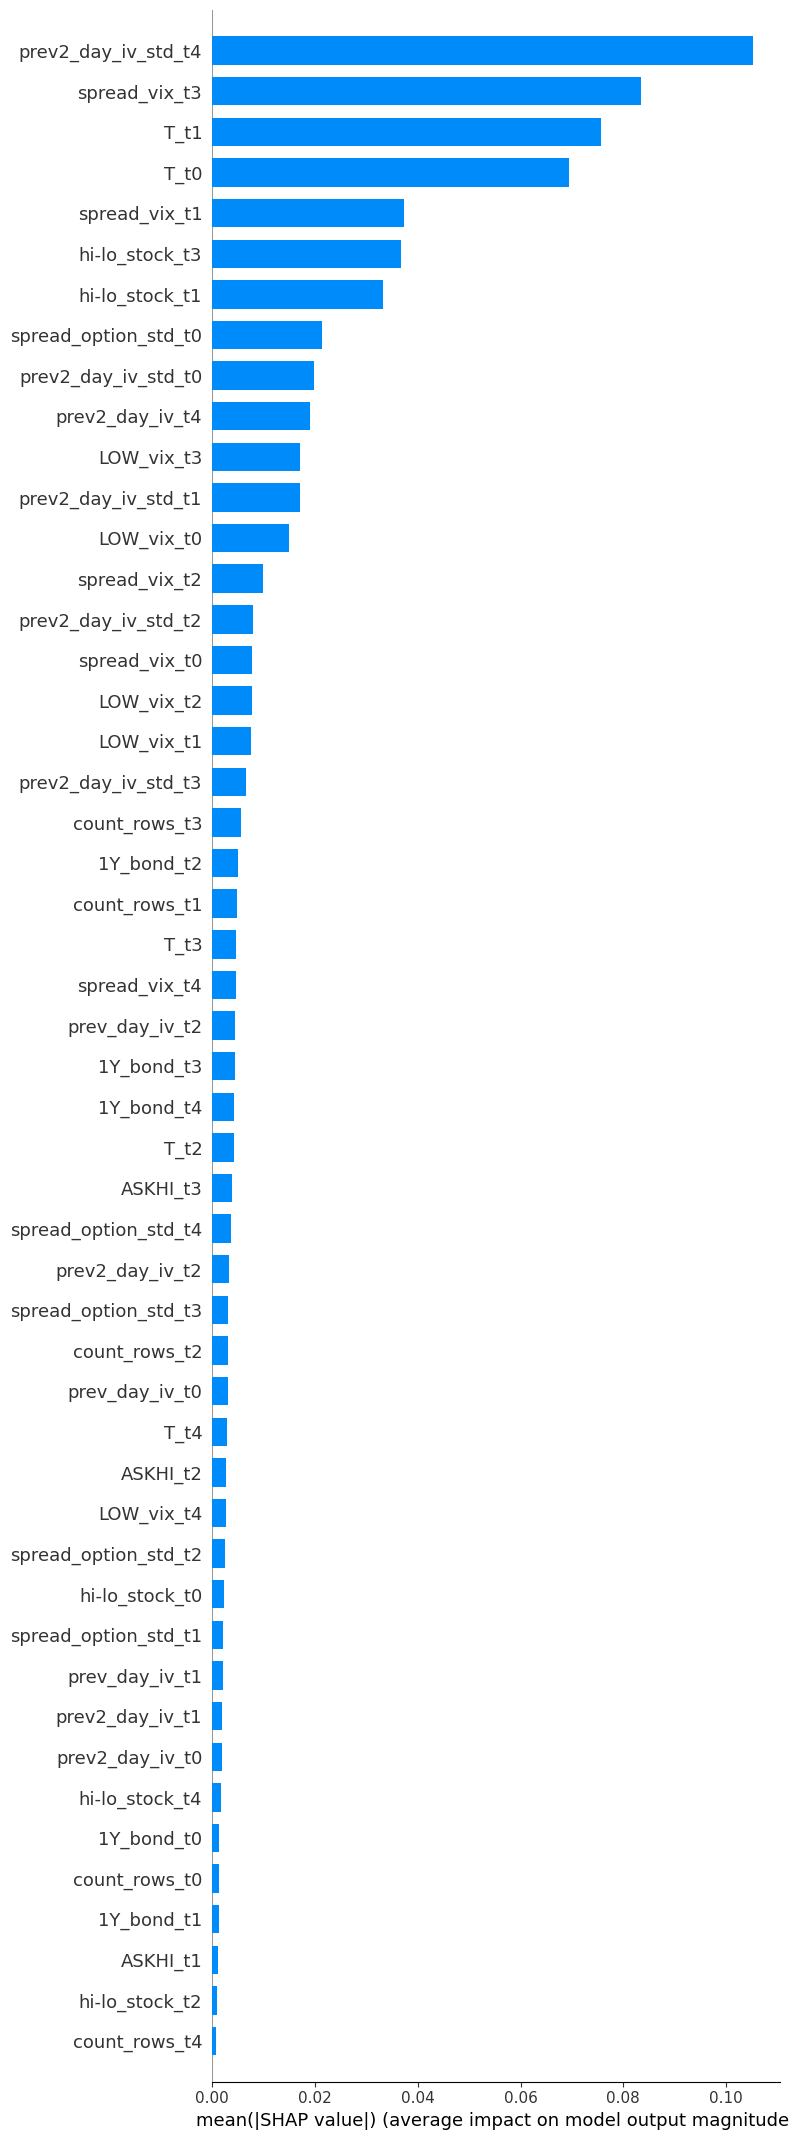

In [27]:
import shap

tot_train_puts = standardized_train_data_p.columns

original_feature_names = tot_train_puts.drop(['impl_volatility', 'date','cp_flag'])

import numpy as np

# Step 1: Flatten the 3D input to 2D
X_train_flattened_p = X_train_reshaped_p.reshape(X_train_reshaped_p.shape[0], -1)

# Step 2: Define a wrapper function for reshaping and making predictions
def predict_with_reshaping(X_flattened):
    """
    A wrapper function that reshapes the 2D input back to 3D for the LSTM model to make predictions.
    
    Parameters:
    X_flattened (np.array): The 2D input array of shape (n_samples, timesteps * n_features).
    
    Returns:
    np.array: Model predictions.
    """
    # Reshape the 2D input back to 3D: (n_samples, timesteps, n_features)
    n_samples = X_flattened.shape[0]
    n_timesteps = X_train_reshaped_p.shape[1]
    n_features = X_train_reshaped_p.shape[2]
    
    X_reshaped = X_flattened.reshape(n_samples, n_timesteps, n_features)
    
    # Make predictions using the LSTM model
    return best_model_p.predict(X_reshaped)

# Step 3: Use KernelExplainer with the flattened input and the reshaping wrapper function
# Select a small background sample to make KernelExplainer faster
background = X_train_flattened_p[np.random.choice(X_train_flattened_p.shape[0], 50, replace=False)]

# Initialize KernelExplainer with the prediction function and background
kernel_explainer = shap.KernelExplainer(predict_with_reshaping, background)

# Compute SHAP values for the flattened input
shap_values = kernel_explainer.shap_values(X_train_flattened_p)

# Step 4: Visualize the SHAP values
shap.initjs()

# Expand feature names to match the flattened 2D structure (if needed)
n_timesteps = X_train_reshaped_p.shape[1]
expanded_feature_names = [f'{feat}_t{t}' for feat in original_feature_names for t in range(n_timesteps)]

# Generate SHAP summary plot
shap.summary_plot(shap_values, X_train_flattened_p, feature_names=expanded_feature_names, max_display=50, plot_type='bar')


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 578us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 554us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 608us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 590us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 567us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 560us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 602us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 616us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 600us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 580us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 656us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 624us/step
1/1 

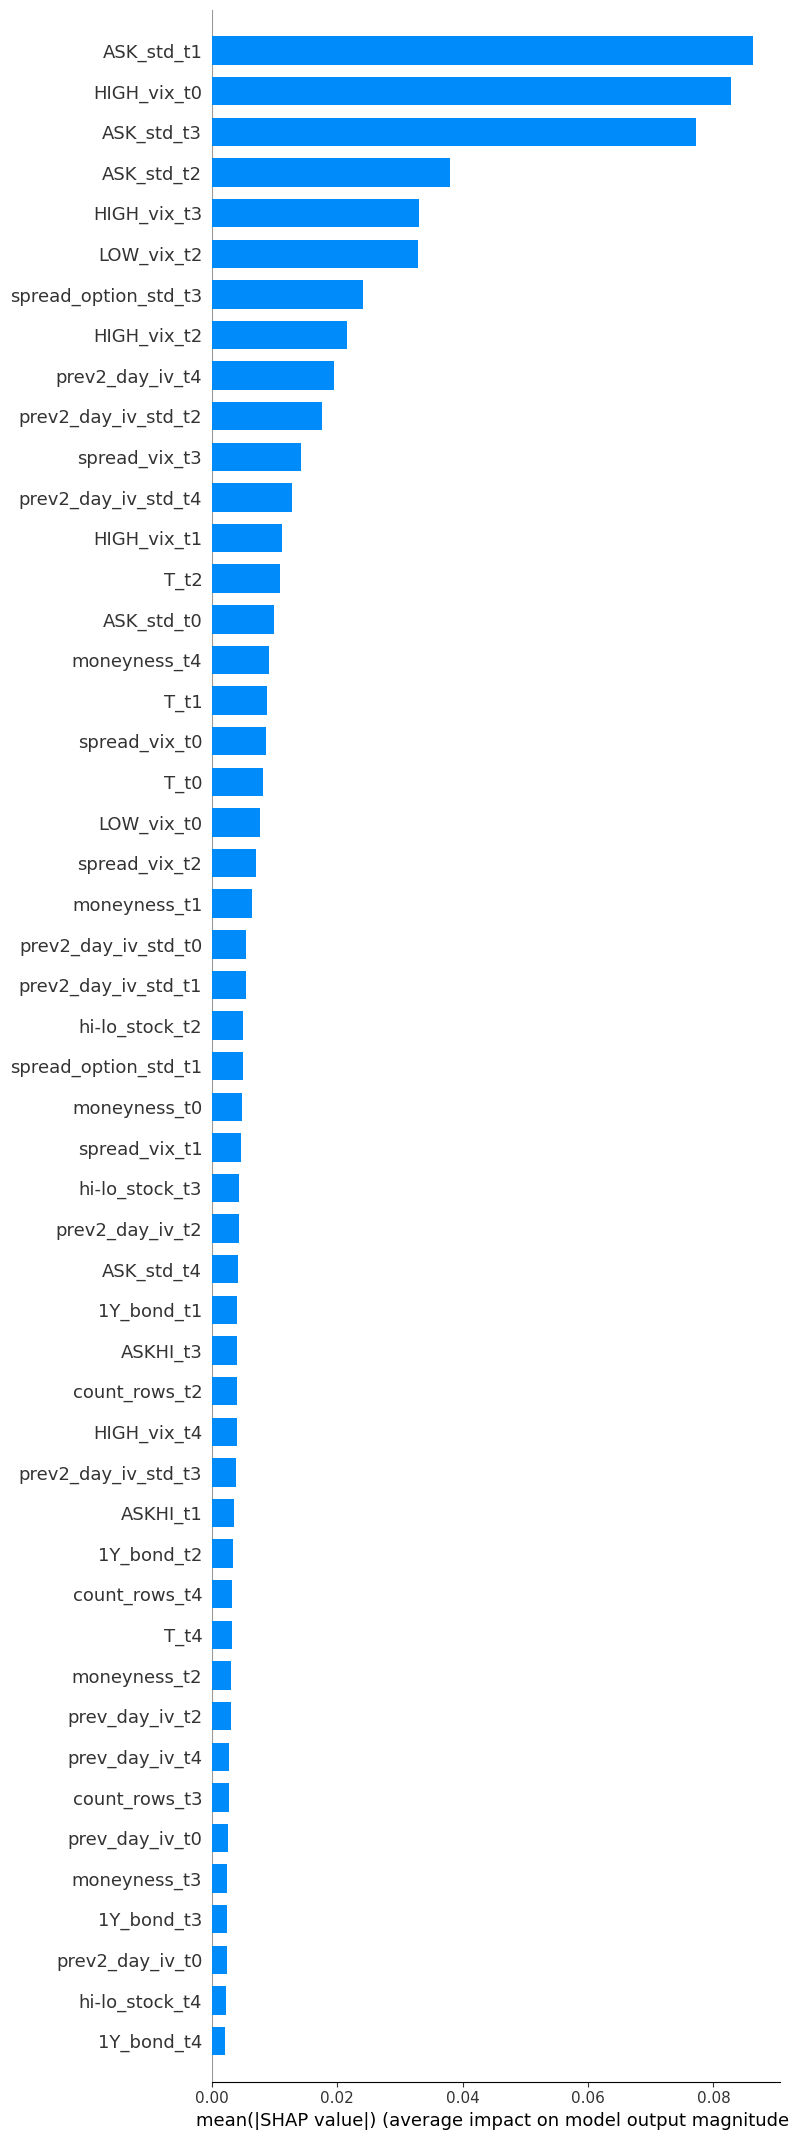

In [23]:
import shap

tot_train_puts = standardized_train_data_c.columns

original_feature_names = tot_train_puts.drop(['impl_volatility', 'date','cp_flag'])

import numpy as np

# Step 1: Flatten the 3D input to 2D
X_train_flattened_p = X_train_reshaped_c.reshape(X_train_reshaped_c.shape[0], -1)

# Step 2: Define a wrapper function for reshaping and making predictions
def predict_with_reshaping(X_flattened):
    """
    A wrapper function that reshapes the 2D input back to 3D for the LSTM model to make predictions.
    
    Parameters:
    X_flattened (np.array): The 2D input array of shape (n_samples, timesteps * n_features).
    
    Returns:
    np.array: Model predictions.
    """
    # Reshape the 2D input back to 3D: (n_samples, timesteps, n_features)
    n_samples = X_flattened.shape[0]
    n_timesteps = X_train_reshaped_c.shape[1]
    n_features = X_train_reshaped_c.shape[2]
    
    X_reshaped = X_flattened.reshape(n_samples, n_timesteps, n_features)
    
    # Make predictions using the LSTM model
    return best_model_c.predict(X_reshaped)

# Step 3: Use KernelExplainer with the flattened input and the reshaping wrapper function
# Select a small background sample to make KernelExplainer faster
background = X_train_flattened_p[np.random.choice(X_train_flattened_p.shape[0], 50, replace=False)]

# Initialize KernelExplainer with the prediction function and background
kernel_explainer = shap.KernelExplainer(predict_with_reshaping, background)

# Compute SHAP values for the flattened input
shap_values = kernel_explainer.shap_values(X_train_flattened_p)

# Step 4: Visualize the SHAP values
shap.initjs()

# Expand feature names to match the flattened 2D structure (if needed)
n_timesteps = X_train_reshaped_c.shape[1]
expanded_feature_names = [f'{feat}_t{t}' for feat in original_feature_names for t in range(n_timesteps)]

# Generate SHAP summary plot
shap.summary_plot(shap_values, X_train_flattened_p, feature_names=expanded_feature_names, max_display=50, plot_type='bar')


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 617us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 625us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 631us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 679us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 621us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 607us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 3s 844us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 3s 925us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 598us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 633us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 607us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 606us/step
1/1 

  0%|          | 0/498 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 584us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 580us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 607us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 623us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 598us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 637us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 584us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 688us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 606us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 697us/step
1/1 ━━━━

IndexError: list index out of range

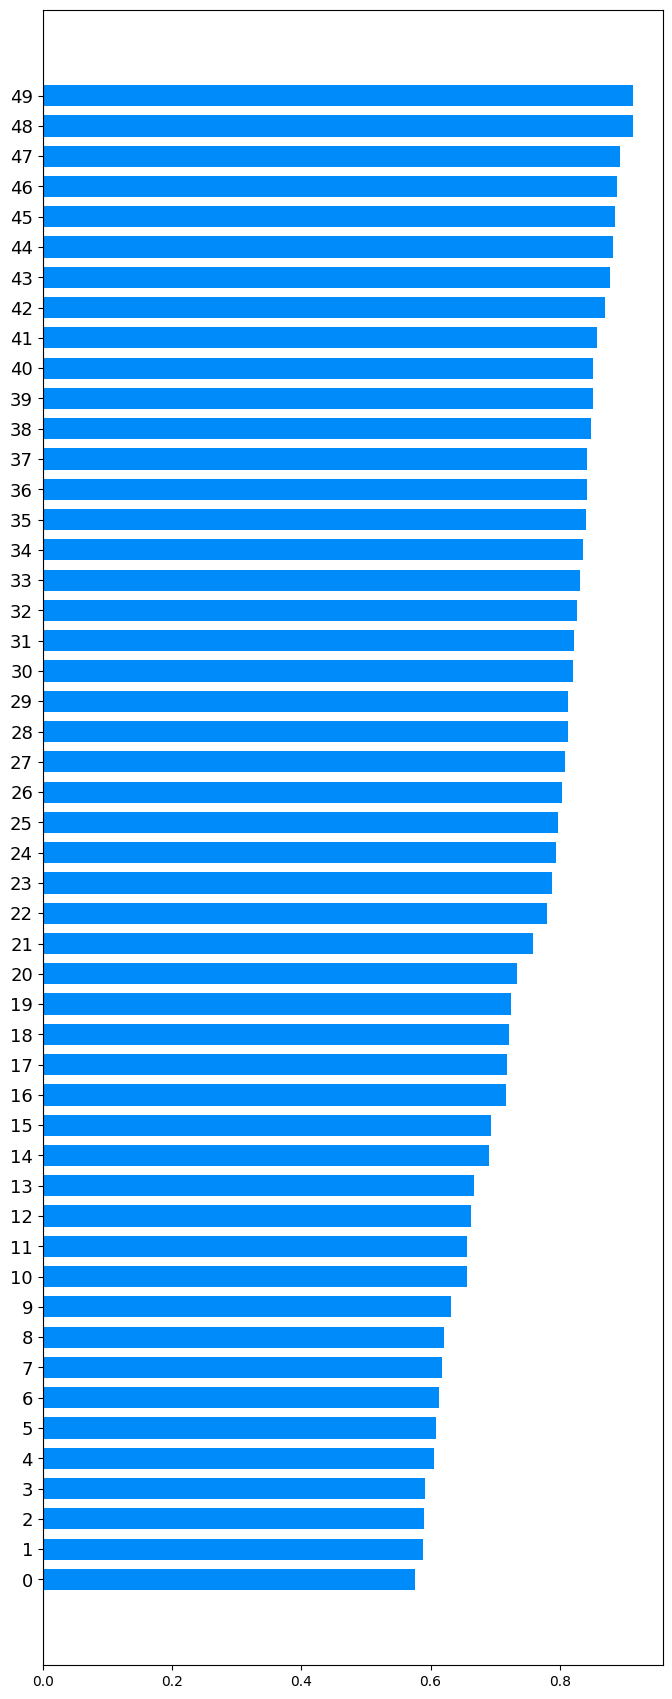

In [28]:
import shap
import numpy as np
from sklearn.preprocessing import MinMaxScaler

tot_train_calls = standardized_train_data_c.columns
tot_train_puts = standardized_train_data_p.columns

original_feature_names_p = tot_train_calls.drop(['impl_volatility', 'date','cp_flag'])
original_feature_names_c = tot_train_puts.drop(['impl_volatility', 'date','cp_flag'])


# Step 1: Flatten the 3D input for Calls and Puts separately
X_train_flattened_c = X_train_reshaped_c.reshape(X_train_reshaped_c.shape[0], -1)  # Calls
X_train_flattened_p = X_train_reshaped_p.reshape(X_train_reshaped_p.shape[0], -1)  # Puts

# Define wrapper function for reshaping and making predictions for each model
def predict_with_reshaping_call(X_flattened):
    """ Reshaping and predicting for Call model. """
    n_samples = X_flattened.shape[0]
    n_timesteps = X_train_reshaped_c.shape[1]
    n_features = X_train_reshaped_c.shape[2]
    
    X_reshaped = X_flattened.reshape(n_samples, n_timesteps, n_features)
    return best_model_c.predict(X_reshaped)  # Call model prediction

def predict_with_reshaping_put(X_flattened):
    """ Reshaping and predicting for Put model. """
    n_samples = X_flattened.shape[0]
    n_timesteps = X_train_reshaped_p.shape[1]
    n_features = X_train_reshaped_p.shape[2]
    
    X_reshaped = X_flattened.reshape(n_samples, n_timesteps, n_features)
    return best_model_p.predict(X_reshaped)  # Put model prediction

# Step 2: Compute SHAP values separately for Calls and Puts

# Select background sample for KernelExplainer (same for both models)
background_call = X_train_flattened_c[np.random.choice(X_train_flattened_c.shape[0], 50, replace=False)]
background_put = X_train_flattened_p[np.random.choice(X_train_flattened_p.shape[0], 50, replace=False)]

# Initialize KernelExplainer for each model
kernel_explainer_call = shap.KernelExplainer(predict_with_reshaping_call, background_call)
kernel_explainer_put = shap.KernelExplainer(predict_with_reshaping_put, background_put)

# Compute SHAP values for each model
shap_values_call = kernel_explainer_call.shap_values(X_train_flattened_c)
shap_values_put = kernel_explainer_put.shap_values(X_train_flattened_p)

# Step 3: Normalize SHAP values for each model to a range [0, 1]
scaler_call = MinMaxScaler(feature_range=(0, 1))
scaler_put = MinMaxScaler(feature_range=(0, 1))

shap_values_call_normalized = scaler_call.fit_transform(shap_values_call)
shap_values_put_normalized = scaler_put.fit_transform(shap_values_put)

# Step 4: Combine the normalized SHAP values
# Assuming both SHAP values have the same shape, you can concatenate them
shap_values_combined_normalized = np.concatenate([shap_values_call_normalized, shap_values_put_normalized], axis=1)

# Step 5: Visualize the combined SHAP values
shap.initjs()

# Adjust feature names to match both Calls and Puts, and expand to match the flattened 2D structure
n_timesteps_call = X_train_reshaped_c.shape[1]
n_timesteps_put = X_train_reshaped_p.shape[1]

expanded_feature_names_call = [f'{feat}_call_t{t}' for feat in original_feature_names for t in range(n_timesteps_call)]
expanded_feature_names_put = [f'{feat}_put_t{t}' for feat in original_feature_names for t in range(n_timesteps_put)]

# Combine feature names
expanded_feature_names_combined = expanded_feature_names_call + expanded_feature_names_put

# Generate SHAP summary plot with normalized combined SHAP values
shap.summary_plot(shap_values_combined_normalized, 
                  np.concatenate([X_train_flattened_c, X_train_flattened_p], axis=1), 
                  feature_names=expanded_feature_names_combined, 
                  max_display=50, 
                  plot_type='bar')


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 691us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 644us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 677us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 621us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 593us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 638us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 642us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 656us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 619us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 624us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 608us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 618us/step
1/1 

  0%|          | 0/498 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 594us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 608us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 606us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 613us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 612us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 590us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 615us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 622us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 611us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 602us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 606us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 694us/step
1/1 

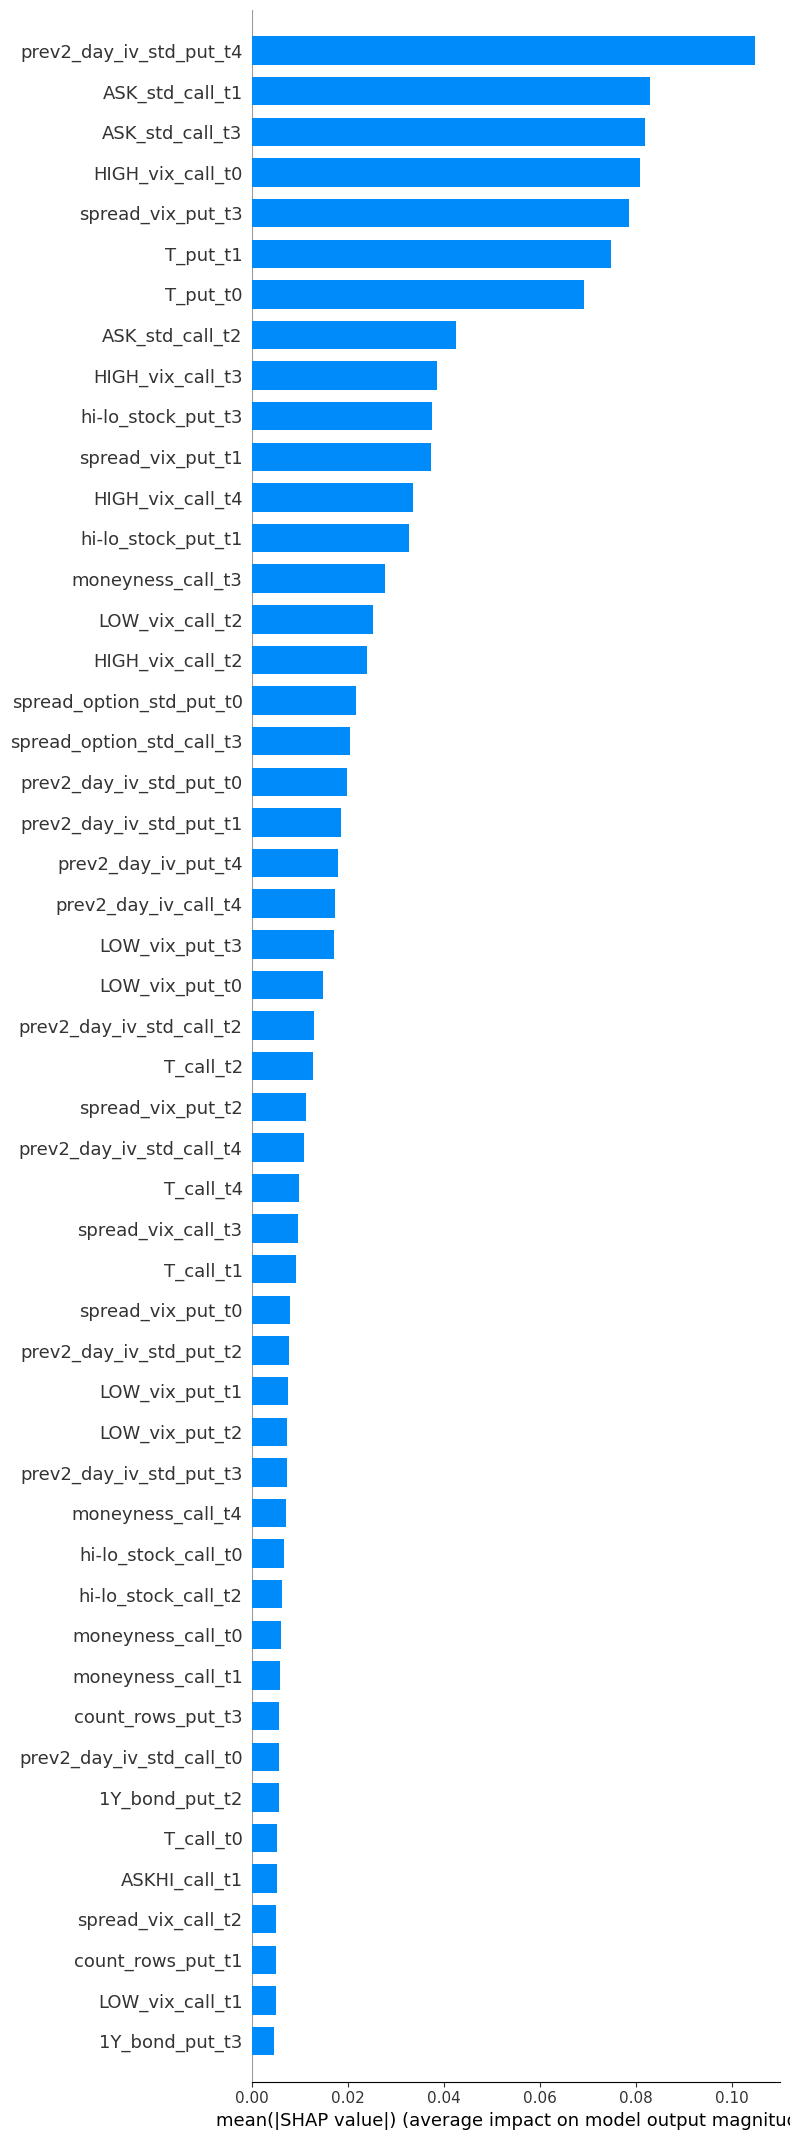

In [54]:
import shap
import numpy as np

# Retrieve feature names for calls and puts, dropping unnecessary columns
tot_train_calls = standardized_train_data_c.columns
tot_train_puts = standardized_train_data_p.columns

# Create original feature names excluding specific columns
original_feature_names_c = tot_train_calls.drop(['impl_volatility', 'date', 'cp_flag'])  # Call-specific feature names
original_feature_names_p = tot_train_puts.drop(['impl_volatility', 'date', 'cp_flag'])  # Put-specific feature names

# Step 1: Flatten the 3D input for Calls and Puts separately
X_train_flattened_c = X_train_reshaped_c.reshape(X_train_reshaped_c.shape[0], -1)  # Calls
X_train_flattened_p = X_train_reshaped_p.reshape(X_train_reshaped_p.shape[0], -1)  # Puts

# Define wrapper function for reshaping and making predictions for each model
def predict_with_reshaping_call(X_flattened):
    """ Reshaping and predicting for Call model. """
    n_samples = X_flattened.shape[0]
    n_timesteps = X_train_reshaped_c.shape[1]
    n_features = X_train_reshaped_c.shape[2]
    X_reshaped = X_flattened.reshape(n_samples, n_timesteps, n_features)
    return best_model_c.predict(X_reshaped)  # Call model prediction

def predict_with_reshaping_put(X_flattened):
    """ Reshaping and predicting for Put model. """
    n_samples = X_flattened.shape[0]
    n_timesteps = X_train_reshaped_p.shape[1]
    n_features = X_train_reshaped_p.shape[2]
    X_reshaped = X_flattened.reshape(n_samples, n_timesteps, n_features)
    return best_model_p.predict(X_reshaped)  # Put model prediction

# Step 2: Compute SHAP values separately for Calls and Puts

# Select background sample for KernelExplainer (same for both models)
background_call = X_train_flattened_c[np.random.choice(X_train_flattened_c.shape[0], 50, replace=False)]
background_put = X_train_flattened_p[np.random.choice(X_train_flattened_p.shape[0], 50, replace=False)]

# Initialize KernelExplainer for each model
kernel_explainer_call = shap.KernelExplainer(predict_with_reshaping_call, background_call)
kernel_explainer_put = shap.KernelExplainer(predict_with_reshaping_put, background_put)

# Compute SHAP values for each model
shap_values_call = kernel_explainer_call.shap_values(X_train_flattened_c)
shap_values_put = kernel_explainer_put.shap_values(X_train_flattened_p)

# No need for normalization: SHAP values already convey magnitude and direction information

# Step 3: Adjust feature names to match both Calls and Puts, and expand to match the flattened 2D structure
n_timesteps_call = X_train_reshaped_c.shape[1]
n_timesteps_put = X_train_reshaped_p.shape[1]

# Correct feature name expansion
expanded_feature_names_call = [f'{feat}_call_t{t}' for feat in original_feature_names_c for t in range(n_timesteps_call)]
expanded_feature_names_put = [f'{feat}_put_t{t}' for feat in original_feature_names_p for t in range(n_timesteps_put)]

# Combine feature names for calls and puts
expanded_feature_names_combined = expanded_feature_names_call + expanded_feature_names_put

# Step 4: Combine the SHAP values for Calls and Puts
# Assuming both SHAP values have the same shape, concatenate them
shap_values_combined = np.concatenate([shap_values_call, shap_values_put], axis=1)

# Step 5: Visualize the combined SHAP values
shap.initjs()

# Generate SHAP summary plot with combined SHAP values (no normalization needed)
shap.summary_plot(shap_values_combined, 
                  np.concatenate([X_train_flattened_c, X_train_flattened_p], axis=1), 
                  feature_names=expanded_feature_names_combined, 
                  max_display=50, 
                  plot_type='bar')


Shape of X_train_flattened_c (calls): (498, 70)
Shape of X_train_flattened_p (puts): (498, 55)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 548us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 569us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 582us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 566us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 607us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 587us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 593us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 584us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 565us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 647us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 550us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 2s 581us/step
1/1 

  0%|          | 0/498 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 548us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 600us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 569us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 567us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 581us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 611us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 644us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 605us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 606us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 585us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 682us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 2s 594us/step
1/1 

SHAP Summary Plot for Calls:


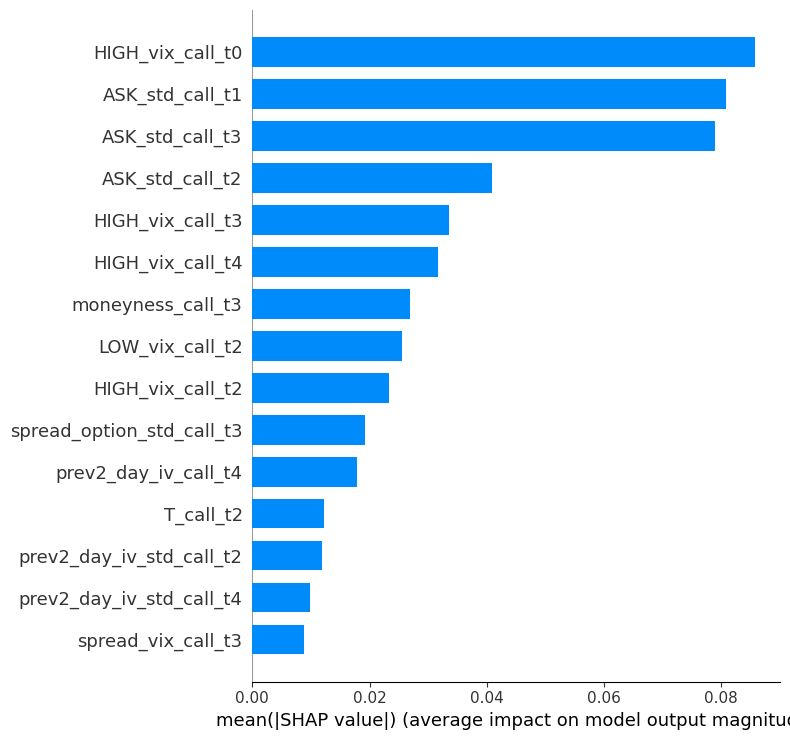

SHAP Summary Plot for Puts:


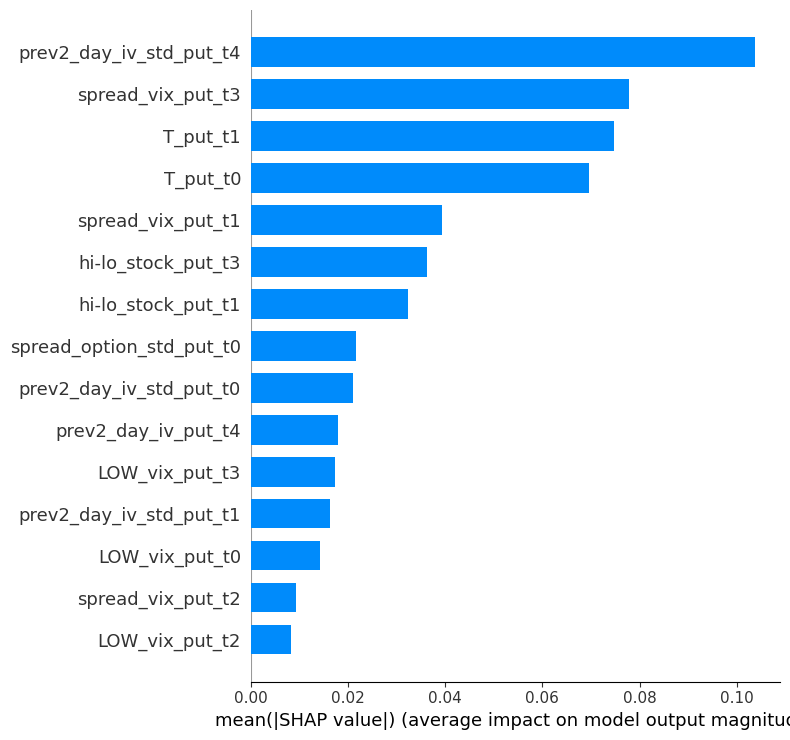

In [15]:
import shap
import numpy as np

# Retrieve feature names for calls and puts, dropping unnecessary columns
tot_train_calls = standardized_train_data_c.columns
tot_train_puts = standardized_train_data_p.columns

# Create original feature names excluding specific columns
original_feature_names_c = tot_train_calls.drop(['impl_volatility', 'date', 'cp_flag'])  # Call-specific feature names
original_feature_names_p = tot_train_puts.drop(['impl_volatility', 'date', 'cp_flag'])  # Put-specific feature names

# Step 1: Flatten the 3D input for Calls and Puts separately
X_train_flattened_c = X_train_reshaped_c.reshape(X_train_reshaped_c.shape[0], -1)  # Calls
X_train_flattened_p = X_train_reshaped_p.reshape(X_train_reshaped_p.shape[0], -1)  # Puts

# Debugging: Print shapes of flattened data
print("Shape of X_train_flattened_c (calls):", X_train_flattened_c.shape)
print("Shape of X_train_flattened_p (puts):", X_train_flattened_p.shape)

# Define wrapper function for reshaping and making predictions for each model
def predict_with_reshaping_call(X_flattened):
    """ Reshaping and predicting for Call model. """
    n_samples = X_flattened.shape[0]
    n_timesteps = X_train_reshaped_c.shape[1]
    n_features = X_train_reshaped_c.shape[2]
    X_reshaped = X_flattened.reshape(n_samples, n_timesteps, n_features)
    return best_model_c.predict(X_reshaped)  # Call model prediction

def predict_with_reshaping_put(X_flattened):
    """ Reshaping and predicting for Put model. """
    n_samples = X_flattened.shape[0]
    n_timesteps = X_train_reshaped_p.shape[1]
    n_features = X_train_reshaped_p.shape[2]
    X_reshaped = X_flattened.reshape(n_samples, n_timesteps, n_features)
    return best_model_p.predict(X_reshaped)  # Put model prediction

# Step 2: Compute SHAP values separately for Calls and Puts

# # Select background sample for KernelExplainer (same for both models)
background_call = X_train_flattened_c[np.random.choice(X_train_flattened_c.shape[0], 50, replace=False)]
background_put = X_train_flattened_p[np.random.choice(X_train_flattened_p.shape[0], 50, replace=False)]

# # Initialize KernelExplainer for each model
kernel_explainer_call = shap.KernelExplainer(predict_with_reshaping_call, background_call)
kernel_explainer_put = shap.KernelExplainer(predict_with_reshaping_put, background_put)

# Compute SHAP values for each model
shap_values_call = kernel_explainer_call.shap_values(X_train_flattened_c)
shap_values_put = kernel_explainer_put.shap_values(X_train_flattened_p)

# Step 3: Adjust feature names to match both Calls and Puts, and expand to match the flattened 2D structure
n_timesteps_call = X_train_reshaped_c.shape[1]
n_timesteps_put = X_train_reshaped_p.shape[1]

# Correct feature name expansion
expanded_feature_names_call = [f'{feat}_call_t{t}' for feat in original_feature_names_c for t in range(n_timesteps_call)]
expanded_feature_names_put = [f'{feat}_put_t{t}' for feat in original_feature_names_p for t in range(n_timesteps_put)]

# Debugging: Print lengths of expanded feature names and SHAP value shapes
print("Length of expanded_feature_names_call:", len(expanded_feature_names_call))
print("Length of expanded_feature_names_put:", len(expanded_feature_names_put))
print("SHAP values call shape:", shap_values_call.shape)
print("SHAP values put shape:", shap_values_put.shape)

# Ensure the lengths match
if len(expanded_feature_names_call) != X_train_flattened_c.shape[1]:
    print(f"Error: Mismatch between the number of call features ({len(expanded_feature_names_call)}) and the number of columns in the flattened data ({X_train_flattened_c.shape[1]}).")
if len(expanded_feature_names_put) != X_train_flattened_p.shape[1]:
    print(f"Error: Mismatch between the number of put features ({len(expanded_feature_names_put)}) and the number of columns in the flattened data ({X_train_flattened_p.shape[1]}).")

# Step 4: Visualize the SHAP values for Calls and Puts separately
shap.initjs()

# Visualize SHAP summary plot for Calls
print("SHAP Summary Plot for Calls:")
shap.summary_plot(shap_values_call, 
                  X_train_flattened_c, 
                  feature_names=expanded_feature_names_call, 
                  max_display=15, 
                  plot_type='bar')

# Visualize SHAP summary plot for Puts
print("SHAP Summary Plot for Puts:")
shap.summary_plot(shap_values_put, 
                  X_train_flattened_p, 
                  feature_names=expanded_feature_names_put, 
                  max_display=15, 
                  plot_type='bar')


Length of expanded_feature_names_call: 70
Length of expanded_feature_names_put: 55
SHAP values call shape: (498, 70)
SHAP values put shape: (498, 55)


SHAP Summary Plot for Calls:


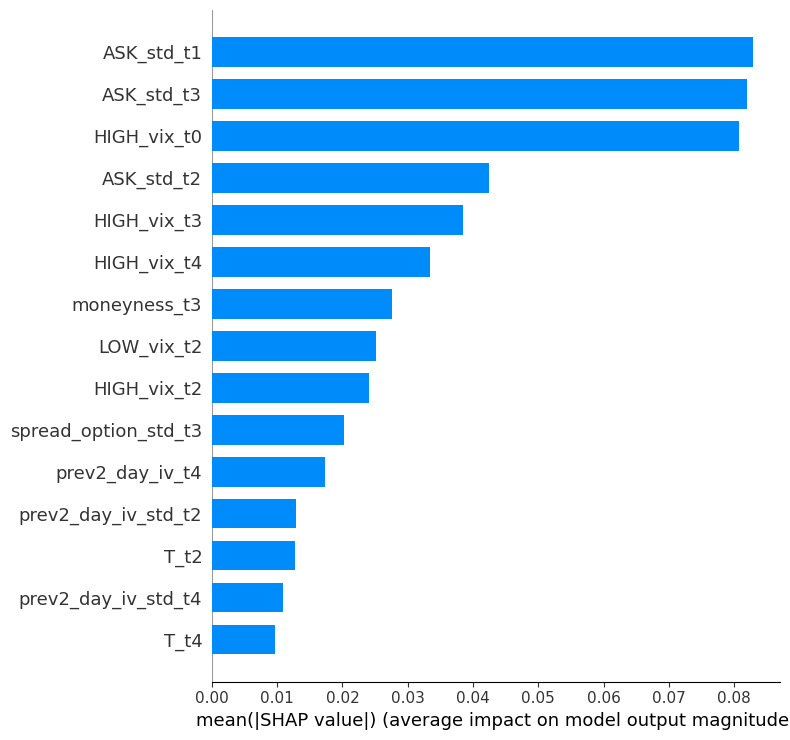

SHAP Summary Plot for Puts:


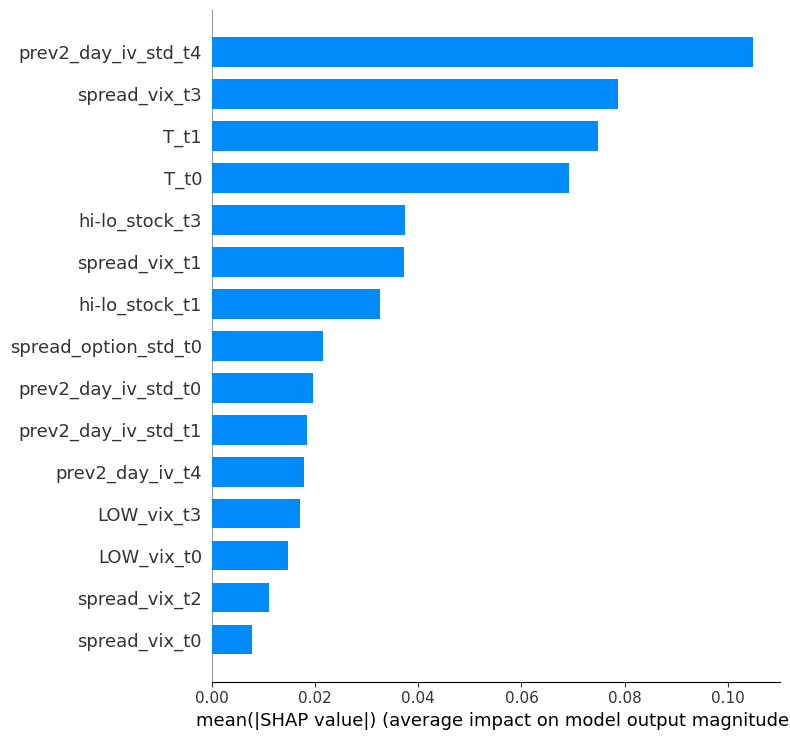

In [101]:
n_timesteps_call = X_train_reshaped_c.shape[1]
n_timesteps_put = X_train_reshaped_p.shape[1]

# Correct feature name expansion without "call" and "put" in the labels
expanded_feature_names_call = [f'{feat}_t{t}' for feat in original_feature_names_c for t in range(n_timesteps_call)]
expanded_feature_names_put = [f'{feat}_t{t}' for feat in original_feature_names_p for t in range(n_timesteps_put)]

# Debugging: Print lengths of expanded feature names and SHAP value shapes
print("Length of expanded_feature_names_call:", len(expanded_feature_names_call))
print("Length of expanded_feature_names_put:", len(expanded_feature_names_put))
print("SHAP values call shape:", shap_values_call.shape)
print("SHAP values put shape:", shap_values_put.shape)

# Ensure the lengths match
if len(expanded_feature_names_call) != X_train_flattened_c.shape[1]:
    print(f"Error: Mismatch between the number of call features ({len(expanded_feature_names_call)}) and the number of columns in the flattened data ({X_train_flattened_c.shape[1]}).")
if len(expanded_feature_names_put) != X_train_flattened_p.shape[1]:
    print(f"Error: Mismatch between the number of put features ({len(expanded_feature_names_put)}) and the number of columns in the flattened data ({X_train_flattened_p.shape[1]}).")

# Step 4: Visualize the SHAP values for Calls and Puts separately
shap.initjs()

# Visualize SHAP summary plot for Calls
print("SHAP Summary Plot for Calls:")
shap.summary_plot(shap_values_call, 
                  X_train_flattened_c, 
                  feature_names=expanded_feature_names_call, 
                  max_display=15, 
                  plot_type='bar')

# Visualize SHAP summary plot for Puts
print("SHAP Summary Plot for Puts:")
shap.summary_plot(shap_values_put, 
                  X_train_flattened_p, 
                  feature_names=expanded_feature_names_put, 
                  max_display=15, 
                  plot_type='bar')


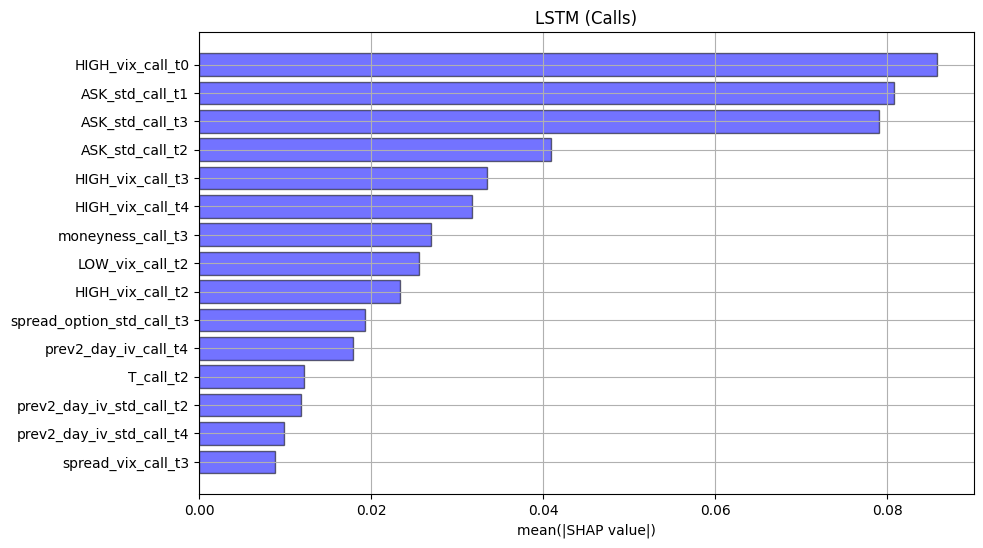

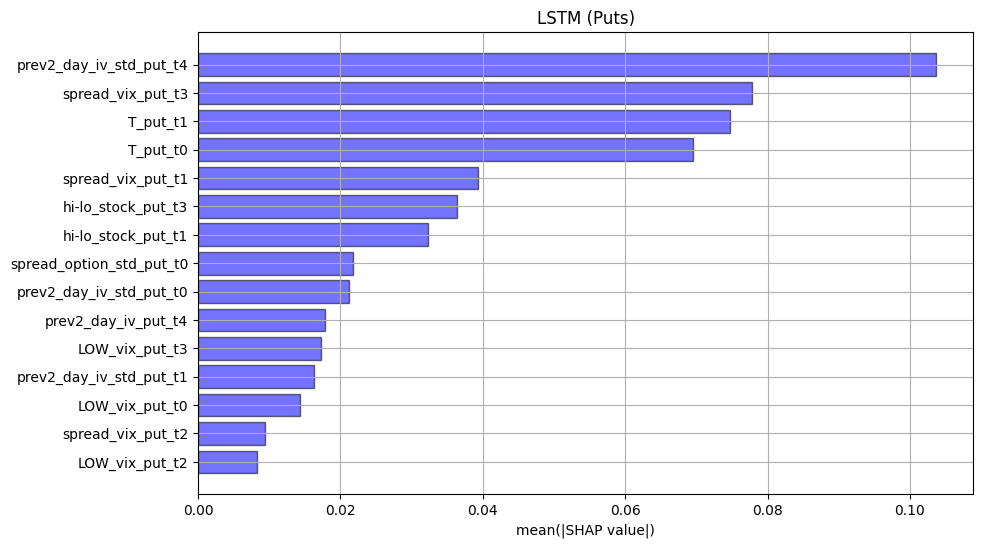

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Get the mean absolute SHAP values for feature importance
mean_shap_values_call = np.mean(np.abs(shap_values_call), axis=0)
mean_shap_values_put = np.mean(np.abs(shap_values_put), axis=0)

# Sort the features by their importance (descending order)
sorted_indices_call = np.argsort(mean_shap_values_call)[::-1][:15]  # Top 15 in descending order
sorted_indices_put = np.argsort(mean_shap_values_put)[::-1][:15]    # Top 15 in descending order

# Plot SHAP values for Calls (high to low)
plt.figure(figsize=(10, 6))
plt.barh([expanded_feature_names_call[i] for i in sorted_indices_call][::-1],  # Reverse the order of labels
         mean_shap_values_call[sorted_indices_call][::-1],  # Reverse the order of values
         color='blue', edgecolor='black', alpha=0.55)
plt.xlabel('mean(|SHAP value|)')
plt.title('LSTM (Calls)')
plt.grid(True)  # Add grid to both axes
plt.show()

# Plot SHAP values for Puts (high to low)
plt.figure(figsize=(10, 6))
plt.barh([expanded_feature_names_put[i] for i in sorted_indices_put][::-1],  # Reverse the order of labels
         mean_shap_values_put[sorted_indices_put][::-1],  # Reverse the order of values
         color='blue', edgecolor='black', alpha=0.55)
plt.xlabel('mean(|SHAP value|)')
plt.title('LSTM (Puts)')
plt.grid(True)  # Add grid to both axes
plt.show()


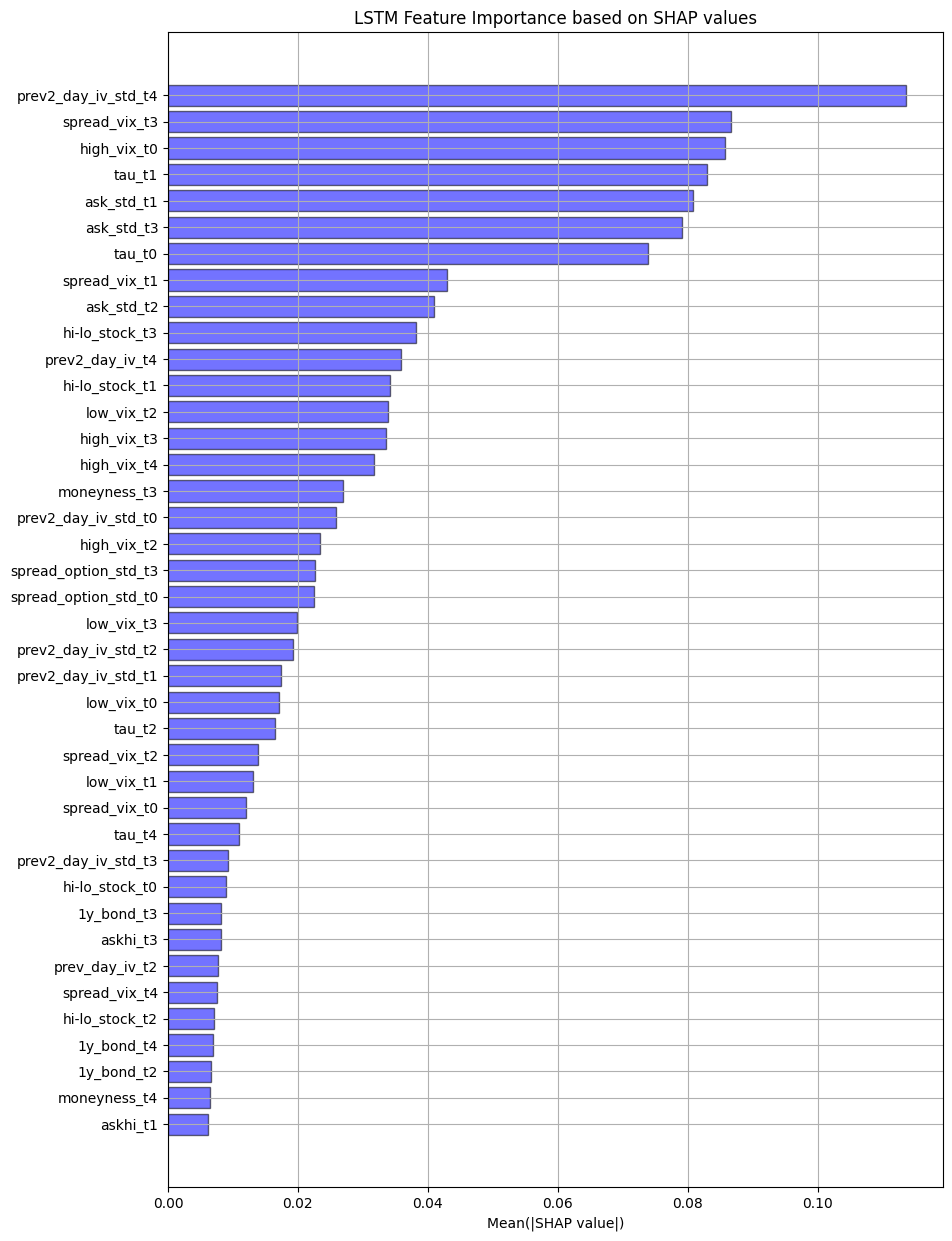

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get the mean absolute SHAP values for feature importance for Calls and Puts
mean_shap_values_call = np.mean(np.abs(shap_values_call), axis=0)
mean_shap_values_put = np.mean(np.abs(shap_values_put), axis=0)

# Combine SHAP values and feature names
mean_shap_values_combined = np.concatenate([mean_shap_values_call, mean_shap_values_put])
expanded_feature_names_combined = expanded_feature_names_call + expanded_feature_names_put

# Create a DataFrame with feature names and their mean absolute SHAP values
shap_values_df = pd.DataFrame({
    'Feature': expanded_feature_names_combined,
    'Mean(|SHAP value|)': mean_shap_values_combined
})

# Remove 'call' and 'put' from feature names
shap_values_df['Feature'] = shap_values_df['Feature'].str.replace('_call', '').str.replace('_put', '')

# Group by feature names and sum the SHAP values
shap_values_df_grouped = shap_values_df.groupby('Feature').sum().reset_index()

# Sort the DataFrame by mean absolute SHAP value in descending order
shap_values_df_sorted = shap_values_df_grouped.sort_values(by='Mean(|SHAP value|)', ascending=False)

# Display the DataFrame
shap_values_df_sorted.reset_index(drop=True, inplace=True)

# Change 'T' to 'tau' and make everything lowercase on the y-axis
shap_values_df_sorted['Feature'] = shap_values_df_sorted['Feature'].str.replace('T', 'tau').str.lower()

fig, ax = plt.subplots(figsize=(10, 15))  # Adjust the figure size for better readability
ax.barh(shap_values_df_sorted['Feature'][:40][::-1],  # Reverse the order of labels for high to low
    shap_values_df_sorted['Mean(|SHAP value|)'][:40][::-1],  # Reverse the order of values for high to low
    color='blue', edgecolor='black', alpha=0.55)
ax.set_xlabel('Mean(|SHAP value|)')
ax.set_title('LSTM Feature Importance based on SHAP values')
ax.grid(True)
plt.show()

shap_values_df_sorted

from matplotlib.backends.backend_pdf import PdfPages

# Create a PDF file to save the plot
with PdfPages('shap_feature_importance.pdf') as pdf:
    pdf.savefig(fig)


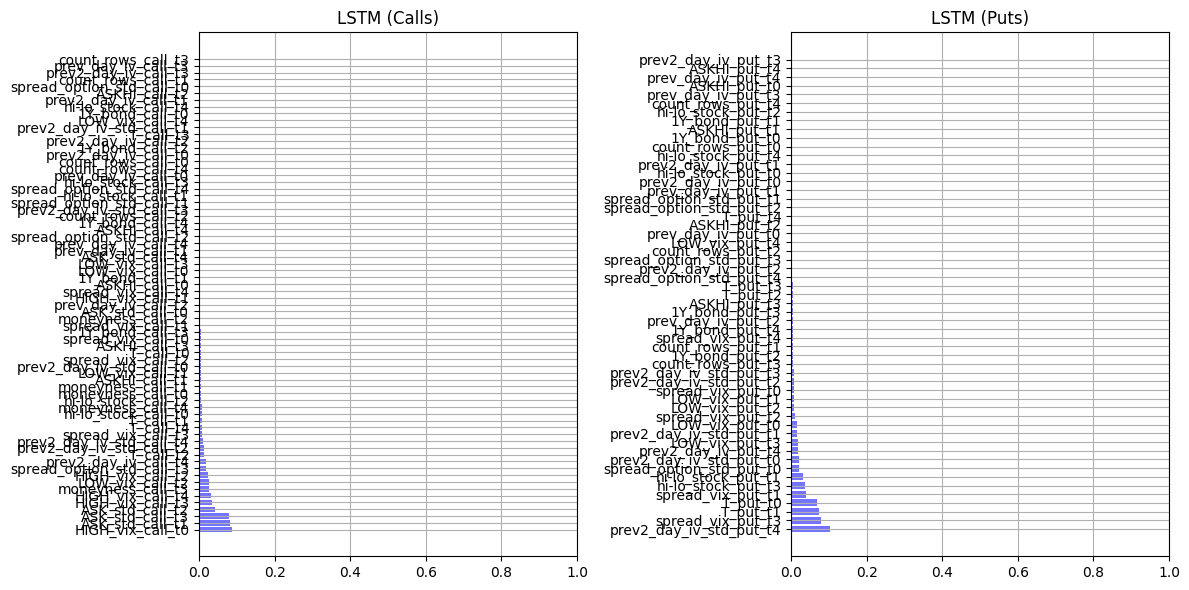

In [44]:
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages

# Get the mean absolute SHAP values for feature importance for Calls and Puts
mean_shap_values_call = np.mean(np.abs(shap_values_call), axis=0)
mean_shap_values_put = np.mean(np.abs(shap_values_put), axis=0)

# Combine SHAP values and feature names
mean_shap_values_combined = np.concatenate([mean_shap_values_call, mean_shap_values_put])
expanded_feature_names_combined = expanded_feature_names_call + expanded_feature_names_put

# Create a DataFrame with feature names and their mean absolute SHAP values
shap_values_df = pd.DataFrame({
    'Feature': expanded_feature_names_combined,
    'Mean(|SHAP value|)': mean_shap_values_combined
})

# Sort the DataFrame by mean absolute SHAP value in descending order
shap_values_df_sorted = shap_values_df.sort_values(by='Mean(|SHAP value|)', ascending=False)

# Display the DataFrame
shap_values_df_sorted.reset_index(drop=True, inplace=True)
shap_values_df_sorted.head(150)

# Define a function to create bar charts for LSTM
def plot_lstm_feature_importance(ax, model_name, importance, features, figsize=None):
    ax.barh(features, importance, color='blue', alpha=0.55)
    ax.set_xlim(0, 1)  # X-axis range between 0 and 1
    ax.set_title(f'{model_name}')
    ax.grid(True)
    if figsize:
        ax.figure.set_size_inches(figsize)

# Sort features and importance by descending order for LSTM Calls and Puts
sorted_indices_call = np.argsort(mean_shap_values_call)[::-1][:120]
sorted_indices_put = np.argsort(mean_shap_values_put)[::-1][:120]

lstm_features_call = [expanded_feature_names_call[i] for i in sorted_indices_call]
lstm_importance_call = mean_shap_values_call[sorted_indices_call]

lstm_features_put = [expanded_feature_names_put[i] for i in sorted_indices_put]
lstm_importance_put = mean_shap_values_put[sorted_indices_put]

# Create a figure for the LSTM feature importance
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot LSTM Calls and Puts on separate subplots
plot_lstm_feature_importance(axes[0], 'LSTM (Calls)', lstm_importance_call, lstm_features_call)
plot_lstm_feature_importance(axes[1], 'LSTM (Puts)', lstm_importance_put, lstm_features_put)

# Display the figure
plt.tight_layout()
plt.show()

# Save the figure as a PDF
# with PdfPages('lstm_feature_importance_plots.pdf') as pdf:
#     pdf.savefig(fig)



In [778]:
import numpy as np
import random
import tensorflow as tf

# Set the random seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

# Call the function to set the seed to 42
set_seed(42)

import numpy as np
from sklearn.metrics import mean_squared_error

def lstm_permutation_importance(model, X, y, n_repeats=10, random_state=42):
    """
    Perform permutation importance for LSTM models with 3D inputs.
    
    Parameters:
    - model: Trained Keras model (LSTM)
    - X: 3D input data (n_samples, timesteps, n_features)
    - y: Target values
    - n_repeats: Number of times to permute each feature
    - random_state: Random seed for reproducibility
    
    Returns:
    - importances_mean: Mean of permutation importance for each feature
    """
    np.random.seed(random_state)
    baseline_score = mean_squared_error(y, model.predict(X))  # Baseline performance
    n_samples, timesteps, n_features = X.shape
    
    importances = np.zeros((n_repeats, n_features))
    
    # Iterate over each feature
    for feature_idx in range(n_features):
        for repeat in range(n_repeats):
            # Permute the selected feature across all timesteps
            X_permuted = X.copy()
            for t in range(timesteps):
                np.random.shuffle(X_permuted[:, t, feature_idx])  # Shuffle along the feature axis
            
            # Calculate the new score after permutation
            permuted_score = mean_squared_error(y, model.predict(X_permuted))
            
            # Store the difference in performance
            importances[repeat, feature_idx] = permuted_score - baseline_score
    
    # Calculate the mean importance across all repeats
    importances_mean = np.mean(importances, axis=0)
    
    return importances_mean

# Example usage:
importances_lstm = lstm_permutation_importance(best_model_p, X_train_reshaped_p, y_train_p, n_repeats=10, random_state=42)

# Print the importances
print("Feature importances for LSTM:", importances_lstm)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [807]:
tot_train_puts = standardized_train_data_p.columns

original_feature_names = tot_train_puts.drop(['impl_volatility', 'date','cp_flag'])

In [808]:
print(original_feature_names[0:64])

Index(['moneyness', 'T', 'prev_day_iv', 'prev2_day_iv', 'volume_option',
       'spread_option', 'BIDLO', 'ASKHI', 'PRC', 'vol_stock', 'RET', 'BID',
       'ASK', 'RETX', 'PRC_actual', 'cumulative_return',
       'daily_return_indicator_stock', '5_day_rolling_return_stock',
       'hi-lo_stock', 'spread_stock', 'FF_rate', 'gold_price', 'reces_indi',
       '10Y_RIR', '1Y_bond', '2Y_bond', 'OPEN_vix', 'HIGH_vix', 'LOW_vix',
       'CLOSE_vix', 'spread_vix', 'count_rows', 'moneyness_std', 'T_std',
       'prev_day_iv_std', 'prev2_day_iv_std', 'volume_option_std',
       'spread_option_std', 'BIDLO_std', 'ASKHI_std', 'PRC_std',
       'vol_stock_std', 'RET_std', 'BID_std', 'ASK_std', 'RETX_std',
       'PRC_actual_std', 'cumulative_return_std',
       'daily_return_indicator_stock_std', '5_day_rolling_return_stock_std',
       'hi-lo_stock_std', 'spread_stock_std', 'FF_rate_std', 'gold_price_std',
       'reces_indi_std', '10Y_RIR_std', '1Y_bond_std', '2Y_bond_std',
       'OPEN_vix_std',

In [809]:
print(len(original_feature_names))
print(len(importances_lstm))

63
63


In [810]:
importances_lstm

array([5.79795299e-04, 1.62560986e-02, 5.73591677e-03, 3.07739324e-03,
       1.27409612e-03, 8.59704696e-04, 2.58935212e-04, 5.04787650e-04,
       6.94086502e-04, 1.25487298e-04, 1.85504620e-04, 9.71290012e-05,
       4.05633927e-04, 1.66934047e-04, 3.66132890e-04, 1.58633966e-03,
       3.49546949e-04, 4.09305701e-04, 2.16549807e-04, 8.51350218e-05,
       7.97876731e-05, 1.50886427e-04, 7.52109741e-05, 5.37190326e-04,
       2.55002445e-04, 2.73152398e-04, 3.28671730e-04, 7.32003656e-04,
       6.43991446e-04, 1.21438971e-03, 4.25756453e-04, 2.73263274e-02,
       7.89148241e-04, 2.46047527e-03, 2.36552751e-03, 4.09145158e-04,
       3.67257129e-04, 3.05958031e-04, 1.18670313e-03, 1.69446739e-04,
       3.83331037e-04, 1.95487537e-03, 2.03967002e-04, 2.88014797e-04,
       1.32080608e-04, 2.27406351e-04, 1.88517971e-04, 1.90296284e-04,
       2.90780548e-04, 5.58176603e-04, 2.70153423e-04, 1.95638349e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [811]:
# Assuming you have n_timesteps and original_feature_names already defined
n_timesteps = 5  # Number of timesteps
n_features = len(original_feature_names)  # Number of features (63 in this case)

# Step 1: Expand feature names for each timestep
expanded_feature_names = [f'{feat}_t{t}' for feat in original_feature_names for t in range(n_timesteps)]

# Step 2: Check the length of expanded_feature_names
print(f"Number of expanded feature names: {len(expanded_feature_names)}")  # Should match the length of importances_lstm

# Step 3: Reshape importances_lstm if needed (flatten it)
importances_flattened = importances_lstm.flatten()  # Flatten the 2D array (timesteps, features) to 1D

# Step 4: Ensure both arrays have the same length
print(f"Length of importances: {len(importances_flattened)}")  # Should match the number of expanded feature names

# Step 5: Create the DataFrame with expanded feature names and flattened importances
feature_importance_networks = pd.DataFrame({
    'feature': expanded_feature_names,  # Expanded feature names with timesteps
    'importance': importances_flattened  # Flattened importance values
})

# Step 6: Sort the DataFrame by 'importance' in descending order
sorted_importance_p = feature_importance_networks.sort_values(by='importance', ascending=False)

# Step 7: Display the sorted feature importances
print(sorted_importance_p)


Number of expanded feature names: 63
Length of importances: 63
              feature  importance
31      count_rows_t0    0.027326
1                T_t0    0.016256
2      prev_day_iv_t0    0.005736
3     prev2_day_iv_t0    0.003077
33           T_std_t0    0.002460
..                ...         ...
58    OPEN_vix_std_t0    0.000000
59    HIGH_vix_std_t0    0.000000
60     LOW_vix_std_t0    0.000000
61   CLOSE_vix_std_t0    0.000000
62  spread_vix_std_t0    0.000000

[63 rows x 2 columns]


In [774]:
from sklearn.inspection import permutation_importance

from sklearn.inspection import permutation_importance
import numpy as np

# Flatten the 3D data (n_samples, timesteps, n_features) to 2D (n_samples, timesteps * n_features)
n_samples, timesteps, n_features = X_train_reshaped_p.shape
X_train_flattened_p = X_train_reshaped_p.reshape(n_samples, timesteps * n_features)

# Apply permutation importance to the flattened data
results_p = permutation_importance(best_model_p, X_train_flattened_p, y_train_p, n_repeats=10, random_state=42)

# Get the feature importances
importance = results_p.importances_mean

# Print the importance
print("Feature Importances (Flattened LSTM):", importance)


# results_c = permutation_importance(best_model_p, X_train_reshaped_p, y_train_p, n_repeats=1, random_state=42) #NEW
#     # Get the feature importances and feature names
# importance = results_c.importances_mean #NEW


ValueError: X has 2 dimensions, but this KerasRegressor is expecting 3 dimensions in X.

In [ ]:


import pandas as pd

# Get predictions
pred_y = best_model_call.predict(combined_x_c)

# Calculate mean squared error
mse_score = mean_squared_error(combined_y_c, pred_y)

# Assuming 'importance' is a list or array of feature importances
# Create a DataFrame with feature importance scores
feature_importance_networks = pd.DataFrame({
    'feature': combined_x_c.columns,  # Assuming feature names come from 'combined_x_p'
    'importance': importance  # Assuming 'importance' is a list or array of the same length as the number of features
})

# Print the MSE score (separately from the feature importances)
print(f"Mean Squared Error (MSE): {mse_score}")

# Sort by 'importance' in descending order
sorted_importance_c = feature_importance_networks.sort_values(by='importance', ascending=False)

# Display sorted feature importances
(sorted_importance_c)



In [64]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

# Set the seed before training
set_seed(42)

from tensorflow.keras.layers import Input

def create_model(input_shape, neurons=64, layers=2, dropout_rate=0.2):
    model = Sequential()
    
    # Add the Input layer
    model.add(Input(shape=input_shape))
    
    # First LSTM layer
    model.add(LSTM(neurons, activation='softplus', return_sequences=(layers > 1)))
    model.add(Dropout(dropout_rate))

    # Additional LSTM layers (if any)
    for _ in range(layers - 2):  # Only add intermediate LSTM layers if more than 2 layers
        model.add(LSTM(neurons, activation='softplus', return_sequences=True))
        model.add(Dropout(dropout_rate))
    
    # Final LSTM layer (return_sequences=False)
    if layers > 1:
        model.add(LSTM(neurons, activation='softplus', return_sequences=False))
    
    # Output layer for regression
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model


def create_keras_regressor(input_dim, timesteps=5):
    # The input shape should now reflect the number of timesteps and features
    return KerasRegressor(model=create_model, input_shape=(timesteps, input_dim), verbose=1)

# param_grid = {
#     'model__neurons': [16, 32, 64],    # Number of neurons in each hidden layer
#     'model__layers': [1, 2, 3, 4],        # Number of hidden layers
#     'model__dropout_rate': [0, 0.2, 0.5], # Dropout rate
#     'batch_size': [32],                # Batch size for training
#     'epochs': [50],                    # Number of epochs
# }

param_grid = {'batch_size': [32], 'epochs': [50], 'model__dropout_rate': [0], 'model__layers': [1], 'model__neurons': [64]} #Calls

def train_and_evaluate(X_train_reshaped, y_train, X_test_reshaped, y_test, timesteps=5):
    input_dim = X_train_reshaped.shape[2]  # Number of features
    
    # Create KerasRegressor with the correct input dimension
    model = create_keras_regressor(input_dim, timesteps=timesteps)
    
    # Initialize GridSearchCV with the model, parameter grid, and scoring
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               scoring='neg_mean_squared_error',
                               verbose=1,
                               cv=5,
                               n_jobs=-1)

    # Perform the grid search
    grid_search.fit(X_train_reshaped, y_train)

    # Get the best estimator and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print(f"Best Parameters: {best_params}")

    # In-sample evaluation on the training set
    predictions_train = np.squeeze(best_model.predict(X_train_reshaped))
    print("predictions_train shape:", predictions_train.shape)
    print("y_train shape:", y_train.shape)
    
    # Check if shapes match
    if predictions_train.shape != y_train.shape:
        raise ValueError(f"Mismatch between predictions ({predictions_train.shape}) and y_train ({y_train.shape}) shape")
    
    r2_train = r2_score(y_train, predictions_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, predictions_train))
    
    print(f"In-sample R²: {r2_train:.4f}")
    print(f"In-sample RMSE: {rmse_train:.4f}")

    # Out-of-sample evaluation on the test set
    predictions_test = np.squeeze(best_model.predict(X_test_reshaped))
    r2_test = r2_score(y_test, predictions_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, predictions_test))

    print(f"Out-of-sample R²: {r2_test:.4f}")
    print(f"Out-of-sample RMSE: {rmse_test:.4f}")



    return best_model


# num_samples = X_train_reshaped_p.shape[0]  # 498 samples
# num_elements = X_train_reshaped_p.size      # Total number of elements, e.g., 12,450

# # Calculate the number of features per timestep
# num_timesteps = 5  # Set this value based on your understanding of the data
# num_features = num_elements // (num_samples * num_timesteps)  # Calculate the number of features per timestep

# print(f"Number of timesteps: {num_timesteps}")
# print(f"Number of features: {num_features}")

# X_train_reshaped_p = X_train_reshaped_p.reshape((num_samples, num_timesteps, num_features))
# X_test_reshaped_p = X_test_reshaped_p.reshape((X_test_reshaped_p.shape[0], num_timesteps, num_features))

# print("Reshaped X_train_reshaped_p shape:", X_train_reshaped_p.shape)
# print("Reshaped X_test_reshaped_p shape:", X_test_reshaped_p.shape)


# print("X_train_reshaped_p shape after reshape:", X_train_reshaped_p.shape)
# print("X_test_reshaped_p shape after reshape:", X_test_reshaped_p.shape)

train_and_evaluate(X_train_reshaped_c, y_train_c, X_test_reshaped_c, y_test_c)

# Now you can proceed with training the model
# train_and_evaluate(X_train_reshaped_p, y_train_p, X_test_reshaped_p, y_test_p)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9047   
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3094  
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1290   
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1173 
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0805 
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1826   
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0387 
Epoch 3/50
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0446 
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0352 
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4532   
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0187 
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0394 
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0201 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 

KerasRegressor(
	model=<function create_model at 0x102dacd60>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
	input_shape=(5, 63)
	model__dropout_rate=0
	model__layers=1
	model__neurons=64
)

In [658]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error, r2_score
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from scikeras.wrappers import KerasRegressor

# # Function to create the LSTM model with specified hyperparameters
# def create_model(input_shape, neurons=64, layers=2, dropout_rate=0.2):
#     model = Sequential()
#     model.add(LSTM(neurons, input_shape=input_shape, activation='softplus', return_sequences=(layers > 1)))
#     model.add(Dropout(dropout_rate))
#     for _ in range(layers - 1):
#         model.add(LSTM(neurons, activation='softplus', return_sequences=True))
#         model.add(Dropout(dropout_rate))
#     model.add(Dense(1))  # Output layer for regression
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model

# # Wrapping the model in KerasRegressor for use in GridSearchCV
# def create_keras_regressor(input_dim, timesteps=5):
#     # The input shape should now reflect the number of timesteps and features
#     return KerasRegressor(model=create_model, input_shape=(timesteps, input_dim), verbose=1)

# # Define the parameter grid for trials
# # param_grid = {
# #     'model__neurons': [16, 32, 64],    # Number of neurons in each hidden layer
# #     'model__layers': [ 2, 3],        # Number of hidden layers
# #     'model__dropout_rate': [0, 0.2, 0.5], # Dropout rate
# #     'batch_size': [32],                # Batch size for training
# #     'epochs': [50],                    # Number of epochs
# # }

# param_grid = {'batch_size': [32], 'epochs': [50], 'model__dropout_rate': [0], 'model__layers': [2], 'model__neurons': [64]}

# # Function to perform hyperparameter tuning, retrain the model, and test
# def train_and_evaluate(X_train_reshaped, y_train, X_test_reshaped, y_test, timesteps=5):
#     input_dim = X_train_reshaped.shape[2]  # Number of features
    
#     # Create KerasRegressor with the correct input dimension
#     model = create_keras_regressor(input_dim, timesteps=timesteps)
    
#     # Initialize GridSearchCV with the model, parameter grid, and scoring
#     grid_search = GridSearchCV(estimator=model,
#                                param_grid=param_grid,
#                                scoring='neg_mean_squared_error',
#                                verbose=1,
#                                cv=5,
#                                n_jobs=-1)

#     # Perform the grid search
#     grid_search.fit(X_train_reshaped, y_train)

#     # Get the best estimator and parameters
#     best_model = grid_search.best_estimator_
#     best_params = grid_search.best_params_
    
#     print(f"Best Parameters: {best_params}")

#     # In-sample evaluation on the training set
#     predictions_train = best_model.predict(X_train_reshaped)
#     print("predictions_train shape:", predictions_train.shape)
#     print("y_train shape:", y_train.shape)
#     if predictions_train.shape != y_train.shape:
#         raise ValueError("Mismatch between predictions and y_train shape")
    
#     r2_train = r2_score(y_train, predictions_train)
#     rmse_train = np.sqrt(mean_squared_error(y_train, predictions_train))
    
#     print(f"In-sample R²: {r2_train:.4f}")
#     print(f"In-sample RMSE: {rmse_train:.4f}")

#     # Out-of-sample evaluation on the test set
#     predictions_test = best_model.predict(X_test_reshaped)
#     r2_test = r2_score(y_test, predictions_test)
#     rmse_test = np.sqrt(mean_squared_error(y_test, predictions_test))

#     print(f"Out-of-sample R²: {r2_test:.4f}")
#     print(f"Out-of-sample RMSE: {rmse_test:.4f}")

#     return best_model

# # Assuming you have already created `X_train_reshaped`, `y_train`, `X_test_reshaped`, and `y_test` from `create_lstm_sequences_with_target`

# # No need to reshape again, just use the variables directly:
# # X_train_reshaped and y_train are already prepared, same for X_test_reshaped and y_test

# # Now you can proceed with training the model
# # train_and_evaluate(X_train_reshaped_c, y_train_c, X_test_reshaped_c, y_test_c)

# print("X_train_reshaped_p shape:", X_train_reshaped_p.shape)
# print("y_train_p shape:", y_train_p.shape)
# print("X_test_reshaped_p shape:", X_test_reshaped_p.shape)
# print("y_test_p shape:", y_test_p.shape)


# train_and_evaluate(X_train_reshaped_p, y_train_p, X_test_reshaped_p, y_test_p)



In [679]:
import tensorflow as tf
import random

# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

# Set the seed before training
set_seed(42)

from tensorflow.keras.layers import Input

def create_model(input_shape, neurons=64, layers=2, dropout_rate=0.2):
    model = Sequential()
    
    # Add the Input layer
    model.add(Input(shape=input_shape))
    
    # First LSTM layer
    model.add(LSTM(neurons, activation='softplus', return_sequences=(layers > 1)))
    model.add(Dropout(dropout_rate))

    # Additional LSTM layers (if any)
    for _ in range(layers - 2):  # Only add intermediate LSTM layers if more than 2 layers
        model.add(LSTM(neurons, activation='softplus', return_sequences=True))
        model.add(Dropout(dropout_rate))
    
    # Final LSTM layer (return_sequences=False)
    if layers > 1:
        model.add(LSTM(neurons, activation='softplus', return_sequences=False))
    
    # Output layer for regression
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model


def create_keras_regressor(input_dim, timesteps=5):
    # The input shape should now reflect the number of timesteps and features
    return KerasRegressor(model=create_model, input_shape=(timesteps, input_dim), verbose=1)

param_grid = {
    'model__neurons': [16, 32, 64],    # Number of neurons in each hidden layer
    'model__layers': [1, 2, 3, 4],        # Number of hidden layers
    'model__dropout_rate': [0, 0.2, 0.5], # Dropout rate
    'batch_size': [32],                # Batch size for training
    'epochs': [50],                    # Number of epochs
}

# param_grid = {'batch_size': [32], 'epochs': [50], 'model__dropout_rate': [0], 'model__layers': [2], 'model__neurons': [32]} #Calls
# param_grid = {'batch_size': [32], 'epochs': [50], 'model__dropout_rate': [0], 'model__layers': [4], 'model__neurons': [32]} #Puts


def train_and_evaluate(X_train_reshaped, y_train, X_test_reshaped, y_test, timesteps=5):
    input_dim = X_train_reshaped.shape[2]  # Number of features
    
    # Create KerasRegressor with the correct input dimension
    model = create_keras_regressor(input_dim, timesteps=timesteps)
    
    # Initialize GridSearchCV with the model, parameter grid, and scoring
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               scoring='neg_mean_squared_error',
                               verbose=1,
                               cv=5,
                               n_jobs=-1)

    # Perform the grid search
    grid_search.fit(X_train_reshaped, y_train)

    # Get the best estimator and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print(f"Best Parameters: {best_params}")

    # In-sample evaluation on the training set
    predictions_train = np.squeeze(best_model.predict(X_train_reshaped))
    print("predictions_train shape:", predictions_train.shape)
    print("y_train shape:", y_train.shape)
    
    # Check if shapes match
    if predictions_train.shape != y_train.shape:
        raise ValueError(f"Mismatch between predictions ({predictions_train.shape}) and y_train ({y_train.shape}) shape")
    
    r2_train = r2_score(y_train, predictions_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, predictions_train))
    
    print(f"In-sample R²: {r2_train:.4f}")
    print(f"In-sample RMSE: {rmse_train:.4f}")

    # Out-of-sample evaluation on the test set
    predictions_test = np.squeeze(best_model.predict(X_test_reshaped))
    r2_test = r2_score(y_test, predictions_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, predictions_test))

    print(f"Out-of-sample R²: {r2_test:.4f}")
    print(f"Out-of-sample RMSE: {rmse_test:.4f}")



    return best_model


# num_samples = X_train_reshaped_p.shape[0]  # 498 samples
# num_elements = X_train_reshaped_p.size      # Total number of elements, e.g., 12,450

# # Calculate the number of features per timestep
# num_timesteps = 5  # Set this value based on your understanding of the data
# num_features = num_elements // (num_samples * num_timesteps)  # Calculate the number of features per timestep

# print(f"Number of timesteps: {num_timesteps}")
# print(f"Number of features: {num_features}")

# X_train_reshaped_p = X_train_reshaped_p.reshape((num_samples, num_timesteps, num_features))
# X_test_reshaped_p = X_test_reshaped_p.reshape((X_test_reshaped_p.shape[0], num_timesteps, num_features))

# print("Reshaped X_train_reshaped_p shape:", X_train_reshaped_p.shape)
# print("Reshaped X_test_reshaped_p shape:", X_test_reshaped_p.shape)


# print("X_train_reshaped_p shape after reshape:", X_train_reshaped_p.shape)
# print("X_test_reshaped_p shape after reshape:", X_test_reshaped_p.shape)

# train_and_evaluate(X_train_reshaped_c, y_train_c, X_test_reshaped_c, y_test_c)

# Now you can proceed with training the model
train_and_evaluate(X_train_reshaped_p, y_train_p, X_test_reshaped_p, y_test_p)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0474
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2.1782
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0534
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0322 
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0204 
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1230 
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0248 
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0939Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.07547
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 1.0842
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0177  
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0175 
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0709
Epoch 2/50
Epoch 1/50
13/13 

KerasRegressor(
	model=<function create_model at 0x44cfae660>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
	input_shape=(5, 5)
	model__dropout_rate=0
	model__layers=1
	model__neurons=32
)

In [619]:
X_train_reshaped_p, y_train_p, X_test_reshaped_p, y_test_p

(array([[[ 0.2677414 , -0.76275924,  0.04596981, -2.26258788,
          -0.80275173],
         [ 0.32378856, -1.52153618, -0.26650067,  0.26222199,
          -0.81346465],
         [ 0.16783731,  1.51357159,  0.93651067,  0.27752091,
          -0.82802697],
         [-0.06613908,  0.75479465,  1.15524001,  0.2079872 ,
          -0.84154838],
         [ 0.12834259, -0.0039823 ,  0.53029905, -0.04188459,
          -0.67642424]],
 
        [[ 0.32378856, -1.52153618, -0.26650067,  0.26222199,
          -0.81346465],
         [ 0.16783731,  1.51357159,  0.93651067,  0.27752091,
          -0.82802697],
         [-0.06613908,  0.75479465,  1.15524001,  0.2079872 ,
          -0.84154838],
         [ 0.12834259, -0.0039823 ,  0.53029905, -0.04188459,
          -0.67642424],
         [-0.01477227, -0.76275924,  0.09284038,  0.17903382,
          -0.93674657]],
 
        [[ 0.16783731,  1.51357159,  0.93651067,  0.27752091,
          -0.82802697],
         [-0.06613908,  0.75479465,  1.15524001,

In [63]:
# Modify the model architecture for flattened data (fully connected layers)
def create_flat_model(input_dim, neurons=64, layers=2, dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(neurons, input_shape=(input_dim,), activation='softplus'))
    model.add(Dropout(dropout_rate))
    for _ in range(layers - 1):
        model.add(Dense(neurons, activation='softplus'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Adjust the KerasRegressor wrapper accordingly
def create_keras_flat_regressor(input_dim):
    return KerasRegressor(model=create_flat_model, input_dim=input_dim, verbose=1)

# Modify your training function to use the new flat model
# input_dim_flat = 25  # Adjust this based on your flattened data

# Define the parameter grid for trials
# param_grid = {
#     'model__neurons': [16, 32, 64],    # Number of neurons in each hidden layer
#     'model__layers': [1, 2, 3, 4],           # Number of hidden layers
#     'model__dropout_rate': [0, 0.2, 0.5], # Dropout rate
#     'batch_size': [32],                # Batch size for training
#     'epochs': [50],                    # Number of epochs
# }

param_grid = {'batch_size': [32], 'epochs': [50], 'model__dropout_rate': [0], 'model__layers': [4], 'model__neurons': [32]}

# Function to perform hyperparameter tuning, retrain the model, and test
def train_and_evaluate(X_train_reshaped, y_train, X_test_reshaped, y_test):
    # Create KerasRegressor with the correct input dimension
    model = create_keras_flat_regressor(input_dim=input_dim_flat)

    # Initialize GridSearchCV with the model, parameter grid, and scoring
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               scoring='neg_mean_squared_error',  # Scoring based on MSE
                               verbose=1,
                               cv=5,  # Cross-validation
                               n_jobs=-1)  # Use all available cores

    # Perform the grid search
    grid_search.fit(X_train_reshaped, y_train)

    # Get the best estimator and parameters
    best_model = grid_search.best_estimator_

    best_params = grid_search.best_params_

    print(f"Best Parameters: {best_params}")

    # In-sample evaluation on the training set
    predictions_train = best_model.predict(X_train_reshaped)
    r2_train = r2_score(y_train, predictions_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, predictions_train))
    
    print(f"In-sample R²: {r2_train:.4f}")
    print(f"In-sample RMSE: {rmse_train:.4f}")

    # Out-of-sample evaluation on the test set
    predictions_test = best_model.predict(X_test_reshaped)
    r2_test = r2_score(y_test, predictions_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, predictions_test))

    print(f"Out-of-sample R²: {r2_test:.4f}")
    print(f"Out-of-sample RMSE: {rmse_test:.4f}")

    return best_model

# Now you can proceed with training the model
# train_and_evaluate(X_train_reshaped_p, y_train_p, X_test_reshaped_p, y_test_p)


NameError: name 'input_dim_flat' is not defined

In [621]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from scikeras.wrappers import KerasRegressor

# Function to create the LSTM model with specified hyperparameters
def create_model(input_shape, neurons=64, layers=2, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=input_shape, activation='softplus', return_sequences=(layers > 1)))
    model.add(Dropout(dropout_rate))
    for _ in range(layers - 1):
        model.add(LSTM(neurons, activation='softplus', return_sequences=True))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Wrapping the model in KerasRegressor for use in GridSearchCV
def create_keras_regressor(input_dim, timesteps=5):
    # The input shape should now reflect the number of timesteps and features
    return KerasRegressor(model=create_model, input_shape=(timesteps, input_dim), verbose=1)

# Define the parameter grid for trials
param_grid = {
    'model__neurons': [16, 32, 64],    # Number of neurons in each hidden layer
    'model__layers': [ 2, 3],        # Number of hidden layers
    'model__dropout_rate': [0, 0.2, 0.5], # Dropout rate
    'batch_size': [32],                # Batch size for training
    'epochs': [50],                    # Number of epochs
}

# Function to perform hyperparameter tuning, retrain the model, and test
def train_and_evaluate(X_train_reshaped, y_train, X_test_reshaped, y_test, timesteps=5):
    input_dim = X_train_reshaped.shape[2]  # Number of features

    # Create KerasRegressor with the correct input dimension
    model = create_keras_regressor(input_dim, timesteps=timesteps)

    # Initialize GridSearchCV with the model, parameter grid, and scoring
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               scoring='neg_mean_squared_error',  # Scoring based on MSE
                               verbose=1,
                               cv=5,  # Cross-validation
                               n_jobs=-1)  # Use all available cores

    # Perform the grid search
    grid_search.fit(X_train_reshaped, y_train)

    # Get the best estimator and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print(f"Best Parameters: {best_params}")

    # In-sample evaluation on the training set
    predictions_train = best_model.predict(X_train_reshaped)
    r2_train = r2_score(y_train, predictions_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, predictions_train))
    
    print(f"In-sample R²: {r2_train:.4f}")
    print(f"In-sample RMSE: {rmse_train:.4f}")

    # Out-of-sample evaluation on the test set
    predictions_test = best_model.predict(X_test_reshaped)
    r2_test = r2_score(y_test, predictions_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, predictions_test))

    print(f"Out-of-sample R²: {r2_test:.4f}")
    print(f"Out-of-sample RMSE: {rmse_test:.4f}")

    return best_model

# Assuming you have already created `X_train_reshaped`, `y_train`, `X_test_reshaped`, and `y_test` from `create_lstm_sequences_with_target`

# No need to reshape again, just use the variables directly:
# X_train_reshaped and y_train are already prepared, same for X_test_reshaped and y_test

# Now you can proceed with training the model
# train_and_evaluate(X_train_reshaped_c, y_train_c, X_test_reshaped_c, y_test_c)

train_and_evaluate(X_train_reshaped_p, y_train_p, X_test_reshaped_p, y_test_p)



Fitting 5 folds for each of 18 candidates, totalling 90 fits


/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs

Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1013
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3373
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.3372
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0621 
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0628
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 6.3001
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1827
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0980
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0645
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.3904Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0655
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0453 
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1433 
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0732 
Epoch 4/50
13/13 ━━━

/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/metrics/_s

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step
 6/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0728Epoch 1/50
 9/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0714Epoch 1/50
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0701
Epoch 43/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0949

/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/metrics/_s

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - loss: 0.0753
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0726
Epoch 44/50
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0716Epoch 1/50
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0682
Epoch 45/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0585
Epoch 46/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/stepp - loss: 0.050
 8/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0593 

/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/metrics/_s

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0621
Epoch 47/50
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0513Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0646
Epoch 48/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0672 
Epoch 49/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0537
Epoch 50/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0606
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step


/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/metrics/_s

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.9839
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2942
Epoch 3/50
 1/13 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - loss: 0.093905

KeyboardInterrupt: 

In [85]:
shap_values_put_abs[:, top_15_put_indices]

array([[0.00947865, 0.01473767, 0.02174656, ..., 0.08519338, 0.01954436,
        0.03692771],
       [0.00095125, 0.01387454, 0.0120185 , ..., 0.0411853 , 0.0554874 ,
        0.01693366],
       [0.00466506, 0.01837367, 0.00285483, ..., 0.02781855, 0.1339008 ,
        0.01696861],
       ...,
       [0.00317962, 0.00868202, 0.00855782, ..., 0.02019344, 0.01556183,
        0.11581833],
       [0.00180571, 0.00896499, 0.00624119, ..., 0.0457207 , 0.04387632,
        0.04462137],
       [0.01892016, 0.00926246, 0.00956212, ..., 0.06741664, 0.11087623,
        0.07313868]])

In [268]:
# data_train_p = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_train_tech_scaled_p.parquet')
# data_train_c = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_train_tech_scaled_c.parquet')

# data_val_p = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_val_tech_scaled_p.parquet')
# data_val_c = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_val_tech_scaled_c.parquet')

# data_test_p = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_test_tech_scaled_p.parquet')
# data_test_c = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_test_tech_scaled_c.parquet')

# tot_data_train_c = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_train_val_tech_scaled_c.parquet')
# tot_data_train_p = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_train_val_tech_scaled_p.parquet')

# firm_data = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Firm_variables/daily_firm_data_median_new.parquet')

# data_train = pd.concat([data_train_p, data_train_c], axis=0)
# data_val = pd.concat([data_val_p, data_val_c], axis=0)
# data_test = pd.concat([data_test_p, data_test_c], axis=0)
# data_train_tot = pd.concat([tot_data_train_c, tot_data_train_p], axis=0)

# # # List of columns to drop
# # columns_to_drop = ['trading_days_till_exp'] + list(firm_data.columns[2:])
# # # columns_to_drop = ['trading_days_till_exp']

# # # Drop columns from datasets if they exist
# # data_train = data_train.drop(columns=columns_to_drop, errors='ignore')
# # data_val = data_val.drop(columns=columns_to_drop, errors='ignore')
# # data_test = data_test.drop(columns=columns_to_drop, errors='ignore')
# # data_train_tot = data_train_tot.drop(columns=columns_to_drop, errors='ignore')

# # Ensure that data_val and data_test have the same column order as data_train
# data_val = data_val[data_train.columns]
# data_test = data_test[data_train.columns]
# tot_data_train = data_train_tot[data_train.columns]



In [269]:
# # Top features for Call and Put options
# top_features_c = ['cp_flag', 'Ticker', 'date', 'moneyness', 'impl_volatility', 
#                   'prev_day_iv', 'idiovol', 'T', 
#                   'prev2_day_iv', 'moneyness', '1Y_bond', 'vol_stock']

# top_features_p = ['cp_flag', 'Ticker', 'date', 'moneyness', 'impl_volatility', 
#                   'prev_day_iv', 'T', 'prev2_day_iv', 
#                   'idiovol', 'moneyness', 'vol_stock']

# # Prepare train data for Call and Put options
# data_train_c = data_train[data_train['cp_flag'] == 'C'][top_features_c]
# data_train_p = data_train[data_train['cp_flag'] == 'P'][top_features_p]

# # Prepare validation data for Call and Put options
# data_validate_c = data_val[data_val['cp_flag'] == 'C'][top_features_c]
# data_validate_p = data_val[data_val['cp_flag'] == 'P'][top_features_p]

# # Prepare the total train data for Call and Put options
# data_train_tot_c = tot_data_train[tot_data_train['cp_flag'] == 'C'][top_features_c]
# data_train_tot_p = tot_data_train[tot_data_train['cp_flag'] == 'P'][top_features_p]

# # Prepare test data for Call and Put options
# data_test_c = data_test[data_test['cp_flag'] == 'C'][top_features_c]
# data_test_p = data_test[data_test['cp_flag'] == 'P'][top_features_p]

In [270]:
# # Prepare train, validation, and test data for Call options
# train_x_c = data_train_c.drop(columns=['impl_volatility', 'date', 'Ticker', 'cp_flag'])
# train_y_c = data_train_c['impl_volatility']

# validate_x_c = data_validate_c.drop(columns=['impl_volatility', 'date', 'Ticker', 'cp_flag'])
# validate_y_c = data_validate_c['impl_volatility']

# combined_x_c = data_train_tot_c.drop(columns=['impl_volatility', 'date', 'Ticker', 'cp_flag'])
# combined_y_c = data_train_tot_c['impl_volatility']

# test_x_c = data_test_c.drop(columns=['impl_volatility', 'date', 'Ticker', 'cp_flag'])
# test_y_c = data_test_c['impl_volatility']

# # Prepare train, validation, and test data for Put options
# train_x_p = data_train_p.drop(columns=['impl_volatility', 'date', 'Ticker', 'cp_flag'])
# train_y_p = data_train_p['impl_volatility']

# validate_x_p = data_validate_p.drop(columns=['impl_volatility', 'date', 'Ticker', 'cp_flag'])
# validate_y_p = data_validate_p['impl_volatility']

# combined_x_p = data_train_tot_p.drop(columns=['impl_volatility', 'date', 'Ticker', 'cp_flag'])
# combined_y_p = data_train_tot_p['impl_volatility']

# test_x_p = data_test_p.drop(columns=['impl_volatility', 'date', 'Ticker', 'cp_flag'])
# test_y_p = data_test_p['impl_volatility']

In [271]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_squared_error, r2_score
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping
# from scikeras.wrappers import KerasRegressor

# # Define the feature columns and target column
# target_column = 'ImpliedVolatility'

# # Function to create the LSTM model with specified hyperparameters
# def create_model(input_shape, neurons=64, layers=2, dropout_rate=0.2):
#     model = Sequential()
#     model.add(LSTM(neurons, input_shape=input_shape, activation='softplus', return_sequences=(layers > 1)))
#     model.add(Dropout(dropout_rate))
#     for _ in range(layers - 1):
#         model.add(LSTM(neurons, activation='softplus', return_sequences=True))
#         model.add(Dropout(dropout_rate))
#     model.add(Dense(1))  # Output layer for regression
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model

# # Wrapping the model in KerasRegressor for use in GridSearchCV
# def create_keras_regressor(input_dim):
#     return KerasRegressor(model=create_model, input_shape=(1, input_dim), verbose=1)

# # Define the parameter grid for trials
# param_grid = {
#     'model__neurons': [16, 32, 64],    # Number of neurons in each hidden layer
#     'model__layers': [1, 2, 3],        # Number of hidden layers
#     'model__dropout_rate': [0, 0.2, 0.5], # Dropout rate
#     'batch_size': [32],                # Batch size for training
#     'epochs': [50],                    # Number of epochs
# }

# # Function to perform hyperparameter tuning, retrain the model, and test
# def train_and_evaluate(X_train_reshaped, y_train, X_test_reshaped, y_test):
#     input_dim = X_train_reshaped.shape[2]  # Get the number of features from training data

#     # Create KerasRegressor with the correct input dimension
#     model = create_keras_regressor(input_dim)

#     # Initialize GridSearchCV with the model, parameter grid, and scoring
#     grid_search = GridSearchCV(estimator=model,
#                                param_grid=param_grid,
#                                scoring='neg_mean_squared_error',  # Scoring based on MSE
#                                verbose=3,
#                                cv=3,  # Cross-validation
#                                n_jobs=-1)  # Use all available cores

#     # Perform the grid search
#     grid_search.fit(X_train_reshaped, y_train)

#     # Get the best estimator and parameters
#     best_model = grid_search.best_estimator_
#     best_params = grid_search.best_params_

#     print(f"Best Parameters: {best_params}")

#     # In-sample evaluation on the training set
#     predictions_train = best_model.predict(X_train_reshaped)
#     r2_train = r2_score(y_train, predictions_train)
#     rmse_train = np.sqrt(mean_squared_error(y_train, predictions_train))
    
#     print(f"In-sample R²: {r2_train:.4f}")
#     print(f"In-sample RMSE: {rmse_train:.4f}")

#     # Out-of-sample evaluation on the test set
#     predictions_test = best_model.predict(X_test_reshaped)
#     r2_test = r2_score(y_test, predictions_test)
#     rmse_test = np.sqrt(mean_squared_error(y_test, predictions_test))

#     print(f"Out-of-sample R²: {r2_test:.4f}")
#     print(f"Out-of-sample RMSE: {rmse_test:.4f}")

#     return best_model

# # Reshape the data for LSTM (assuming combined_x_c, combined_x_p, test_x_c, test_x_p are pandas DataFrames)

# # Convert DataFrames to NumPy arrays and then reshape
# X_train_reshaped = combined_x_c.values.reshape((combined_x_c.shape[0], 1, combined_x_c.shape[1]))
# X_test_reshaped = test_x_c.values.reshape((test_x_c.shape[0], 1, test_x_c.shape[1]))

# X_train_reshaped_put = combined_x_p.values.reshape((combined_x_p.shape[0], 1, combined_x_p.shape[1]))
# X_test_reshaped_put = test_x_p.values.reshape((test_x_p.shape[0], 1, test_x_p.shape[1]))

# # Now you can proceed with training the model
# train_and_evaluate(X_train_reshaped, combined_y_c, X_test_reshaped, test_y_c)

# print("hello")
# # train_and_evaluate(X_train_reshaped_put, combined_y_p, X_test_reshaped_put, test_y_p)

In [272]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_squared_error, r2_score
# import joblib
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping

# # Assuming df is already defined and preprocessed as in the previous example

# target_column = 'ImpliedVolatility'
# # Adjust the feature_columns based on your actual dataframe

# # Extract features and target
# X = df[feature_columns]
# y = df[target_column]

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# # Scale the data based on the training set
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Reshape data for LSTM: (samples, timesteps, features)
# X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
# X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# # Function to create the LSTM model with specified hyperparameters
# def create_model(hidden_layers=1, units=64, dropout_rate=0.1):
#     model = Sequential()
#     model.add(LSTM(units, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), activation='softplus', return_sequences=(hidden_layers > 1)))
#     model.add(Dropout(dropout_rate))
#     for _ in range(hidden_layers - 1):
#         model.add(LSTM(units, activation='softplus', return_sequences=True))
#         model.add(Dropout(dropout_rate))
#     model.add(Dense(1))  # Output layer for regression
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model

# # Function to manually train the LSTM model with specified hyperparameters
# def train_model(hidden_layers, units, dropout_rate, epochs, batch_size):
#     model = create_model(hidden_layers, units, dropout_rate)
    
#     # Early stopping to avoid overfitting
#     early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
#     # Train the model
#     history = model.fit(
#         X_train_reshaped, y_train,
#         validation_split=0.15,  # Use a portion of the training data for validation
#         epochs=epochs,
#         batch_size=batch_size,
#         callbacks=[early_stopping],
#         verbose=1
#     )
    
#     # Save the model as a .pkl file
#     model_file_name = f"lstm_model_{hidden_layers}layers_{units}units_{dropout_rate}dropout_{epochs}epochs_{batch_size}batch_start64drop_01.pkl"
#     joblib.dump(model, model_file_name)
#     print(f"Model saved as {model_file_name}")
    
#     return model, history

# # Example: Train with specific hyperparameters
# # You can replace these with your desired parameters
# hidden_layers = 2
# units = 32
# dropout_rate = 0.2
# epochs = 50
# batch_size = 32

# # Train the model
# model, history = train_model(hidden_layers, units, dropout_rate, epochs, batch_size)

# # Evaluate the model on the test set
# y_pred = model.predict(X_test_reshaped)
# y_pred_flat = y_pred.flatten()
# y_test_flat = y_test.values.flatten()
# test_mse = mean_squared_error(y_test_flat, y_pred_flat)
# test_r2 = r2_score(y_test_flat, y_pred_flat)

# print(f"Test MSE: {test_mse}")
# print(f"Test R-squared: {test_r2}")

In [273]:
# # Define the LSTM model function
# def create_lstm_model(input_shape, neurons=32, layers=1, dropout_rate=0.0, bias=0.01, activity=0.01):
#     model = Sequential()
    
#     # First LSTM layer with input shape specified
#     model.add(LSTM(neurons, activation='tanh', recurrent_activation='sigmoid',
#                    input_shape=input_shape, return_sequences=(layers > 1),
#                    bias_regularizer=regularizers.L2(bias),
#                    activity_regularizer=regularizers.L2(activity)))
#     model.add(Dropout(dropout_rate))  # Dropout layer after the first LSTM layer

#     # Additional LSTM layers if needed
#     for _ in range(layers - 1):
#         model.add(LSTM(neurons, activation='tanh', recurrent_activation='sigmoid',
#                        return_sequences=(_ < layers - 2)))  # Only return sequences if it's not the last LSTM layer
#         model.add(Dropout(dropout_rate))
    
#     # Output layer for regression (linear activation)
#     model.add(Dense(1, activation='linear'))

#     # Compile the model
#     model.compile(optimizer=RMSprop(learning_rate=0.01),
#                   loss='mean_squared_error',
#                   metrics=['mse'])
#     return model

# # Wrapping the model in KerasRegressor
# def create_lstm_regressor(input_shape):
#     return KerasRegressor(model=create_lstm_model, input_shape=input_shape, verbose=1)

# # Define the parameter grid for trials
# param_grid = {
#     'model__neurons': [8, 16, 32, 64],    # Number of neurons in each LSTM layer
#     'model__layers': [1, 2],              # Number of LSTM layers
#     'model__dropout_rate': [0, 0.2, 0.5], # Dropout rate
#     'batch_size': [32],                   # Batch size for training
#     'epochs': [50],                       # Number of epochs
# }

# # Function to perform hyperparameter tuning, retrain the model, and test
# def train_and_evaluate(train_x, train_y, validate_x, validate_y, combined_x, combined_y, test_x, test_y):
#     # Reshape input data for LSTM (samples, timesteps, features)
#     input_shape = (train_x.shape[1], train_x.shape[2])
    
#     # Create LSTMRegressor with the correct input shape
#     model = create_lstm_regressor(input_shape)

#     # Initialize GridSearchCV with the model, parameter grid, and scoring
#     grid_search = GridSearchCV(estimator=model,
#                                param_grid=param_grid,
#                                scoring='neg_mean_squared_error',  # Scoring based on MSE
#                                verbose=3)  # Verbose=3 for detailed progress tracking

#     # Hyperparameter tuning using validation data
#     print("Running hyperparameter tuning with validation data...")
#     grid_search.fit(train_x, train_y,
#                     validation_data=(validate_x, validate_y),  # Use validation set for tuning
#                     verbose=1)

#     # Get the best estimator and parameters
#     best_model = grid_search.best_estimator_
#     best_params = grid_search.best_params_

#     print(f"Best Parameters: {best_params}")

#     # Retrain on the combined training and validation set with verbose output
#     best_model.fit(combined_x, combined_y, verbose=1)

#     # Make predictions on the test set
#     predictions = best_model.predict(test_x)

#     # Calculate R² and RMSE for the best model
#     r2 = r2_score(test_y, predictions)
#     rmse = np.sqrt(mean_squared_error(test_y, predictions))

#     # Print the results
#     print(f"R²: {r2:.4f}")
#     print(f"RMSE: {rmse:.4f}")
#     return best_model

# # Call the function for Call options data
# print("\nEvaluating Call options...")
# best_model_call = train_and_evaluate(train_x_c, train_y_c, validate_x_c, validate_y_c, combined_x_c, combined_y_c, test_x_c, test_y_c)